# 租房数据分析

## 项目概述

本项目对各城市租房的数据进行分析，主要包括以下两个部分：

- 数据获取
- 数据预处理、分析与可视化

数据获取部分爬取了北京、上海、广州、深圳、南昌这 5 个城市全部租房数据，包含月租金、户型、朝向、面积、板块等信息。

数据预处理、分析与可视化部分处理并计算各种租房数据相关的值，分析了各城市总体租房情况租金的均价、最高价、最低价、中位数等信息，对比了各城市人均 GDP 、平均工资等信息与租房情况的关系，并对以上分析进行了图形化直观展示。

## 数据获取



数据来源于链家官网的租房数据。

首先导入爬取数据需要的库：

In [464]:
import requests # 用于获取网页内容
from bs4 import BeautifulSoup as bs # 用于解析网页内容
import time # 用于延时，避免爬取过快被封IP
import csv # 用于将数据写入 csv 文件

为方便开发时对代码进行调试，设置调试模式开关。调试时打开，最后正确代码执行时关闭，避免输出过多影响报告内容。

伪造请求头用于简单的反爬虫

In [465]:
# 调试模式开关
debug = False

# 伪造请求头
headers = {
    'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) \
                   AppleWebKit/537.36 (KHTML, like Gecko) \
                   Chrome/119.0.0.0 Safari/537.36'
}

为提高代码的复用性和可扩展性，以下是爬虫程序所用到的函数，最后只需要调用 `scrape()` 即可执行完整的爬虫程序：

In [466]:
def getHTMLText(url: str) -> str:
    """获取单个网页的 HTML 字符串内容

    Args:
        url (str): 网页的 URL

    Returns:
        str: 网页的 HTML 字符串内容
    """
    try:
        r = requests.get(url, timeout=30, headers=headers)
        r.raise_for_status() # 如果状态不是200，引发HTTPError异常
        r.encoding = r.apparent_encoding # 使得解码正确
        return r.text
    except:
        return None

def getRentList(rentURL: str) -> list:
    """获取单个网页的租房信息列表

    Args:
        rentURL (str): 网页的 URL

    Raises:
        Exception: 租房信息格式不匹配

    Returns:
        list: 某单个网页租房信息列表，包括标题、行政区、板块、小区、面积、朝向、户型、租金
    """
    rentList = []

    # 获取网页内容
    html = getHTMLText(rentURL)
    if html == None:
        print(f'{rentURL}访问异常') if debug == True else None
        return rentList
    
    # 解析网页内容
    soup = bs(html, 'html.parser')
    house_list = soup.find_all('div', attrs={'class': 'content__list--item--main'})

    for house in house_list:
        # 租房信息的标题
        p = house.find('p', attrs={'class': 'content__list--item--title'})
        if p == None:
            p = house.find('p', attrs={'class': 'content__list--item--title twoline'})
        title = p.find('a').text.strip()
        # 租房信息的描述
        description = house.find('p', attrs={'class': 'content__list--item--des'})
        # 位置
        location = description.find_all('a', attrs={'target': '_blank'})
        # location可能没有
        if len(location) == 0:
            print(f'[{title}] 缺少位置信息，已跳过...') if debug == True else None
            continue
        # 行政区
        district = location[0].text.strip() # district
        # 板块
        block = location[1].text.strip() # block
        # 小区
        community = location[2].text.strip() # community
        try:
            # 把面积、朝向、户型、租金分开
            des = description.get_text(strip=True).split('/')
            # 有时候有广告，第一个元素是 "精选"，手动去除
            if des[0] == '精选':
                des.pop(0)
            # 面积如果是范围取平均值
            area_range = des[1].replace('㎡', '').strip().split('-')
            area = float(area_range[0]) if len(area_range) == 1\
                                        else (float(area_range[0]) + float(area_range[1])) / 2
            # 朝向
            direction = des[2].replace(' ', '')
            check = ['东', '南', '西', '北']
            if not any([ch in direction for ch in check]):
                print(f'[{title}] 朝向不是东南西北中的一个') if debug == True else None
                raise Exception # 朝向不是东南西中的一个，格式不匹配
            # 户型
            type = des[3].strip()
        except:
            print(f'[{title}] 租房信息格式不匹配，已跳过...') if debug == True else None
            continue
        # 租金如果是范围取平均值
        price_range = house.find('span', attrs={'class': 'content__list--item-price'})\
                    .find('em').text.strip()\
                    .split('-')
        price = float(price_range[0]) if len(price_range) == 1\
                                    else (float(price_range[0]) + float(price_range[1])) / 2
        # 将信息添加到列表中
        rentList.append([title, district, block, community, area, direction, type, price])

    return rentList

def getCityRent(city: str, page: int) -> list:
    """获取一个城市若干页的租房信息列表

    Args:
        city (str): 城市的缩写，与链家网站的 URL 一致
        page (int): 要爬取的页数

    Returns:
        list: 某城市若干页的租房信息列表，包括标题、行政区、板块、小区、面积、朝向、户型、租金
    """
    rentList = []
    for i in range(1, page + 1):
        print(f'正在爬取第 {i} 页...') if debug == True else None
        rentURL = f'https://{city}.lianjia.com/zufang/pg{i}/'
        rentList += getRentList(rentURL)
        time.sleep(1) # 延时 1s
    return rentList

def saveRentList(rentList: list, city: str) -> None:
    """将租房信息列表保存到 csv 文件中

    Args:
        rentList (list): 租房信息列表
        city (str): 城市的缩写，与链家网站的 URL 一致
    """
    print(f'正在保存 {city} 租房信息...')
    with open(f'{city}_rent.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['标题', '行政区', '板块', '小区', '面积', '朝向', '户型', '租金'])
        writer.writerows(rentList)
    print(f'{city} 租房信息保存成功!')

def scrape(cites: list, page: int) -> None:
    """爬取多个城市的租房信息

    Args:
        cites (list): 城市列表，与链家网站的 URL 一致
        page (int): 要爬取的页数
    """
    for city in cites:
        print(f'正在爬取 {city} 租房信息...') if debug == True else None
        rentList = getCityRent(city, page)
        saveRentList(rentList, city)
        print(f'{city} 爬取完成!')

执行爬虫进行数据获取：

In [467]:
cites = ['bj', 'sh', 'gz', 'sz', 'nc'] # 爬取的城市
page = 500 # 爬取的页数

if debug == True:
    scrape(cites, page) # 启动爬虫程序

所爬取的五个城市信息存储在以下五个 csv 文件中，数据量为万条以上：

- 北京：`bj_rent.csv`
- 上海：`sh_rent.csv`
- 广州：`gz_rent.csv`
- 深圳：`sz_rent.csv`
- 南昌：`nc_rent.csv`

表头格式为：

```
标题,行政区,板块,小区,面积,朝向,户型,租金
```

## 数据预处理、分析与可视化

使用爬虫程序获取所需要的租房数据后，使用 pandas 进行数据分析，searborn 进行数据可视化

导入需要的库：

In [468]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']

将五个城市的租房数据入读内存，以 DataFrame 的形式保存：

In [469]:
bj_df = pd.read_csv('bj_rent.csv')
bj_df.head()

,标题,行政区,板块,小区,面积,朝向,户型,租金
0,整租·方丹苑 2室1厅 东北,朝阳,潘家园,方丹苑,89.00,东北,2室1厅1卫,7700.0
1,整租·呼家楼新苑 2室1厅 南,朝阳,红庙,呼家楼新苑,55.89,南,2室1厅1卫,7190.0
2,整租·芳群园四区 1室1厅 南/北,丰台,方庄,芳群园四区,47.82,南北,1室1厅1卫,4700.0
3,整租·三羊里 1室0厅 南,大兴,亦庄,三羊里,55.00,南,1室0厅1卫,3500.0
4,整租·南庭新苑南区 1室1厅 西,丰台,新宫,南庭新苑南区,52.00,西,1室1厅1卫,4200.0


In [470]:
sh_df = pd.read_csv('sh_rent.csv')
sh_df.head()

,标题,行政区,板块,小区,面积,朝向,户型,租金
0,整租·经纬弘汇地标家园 2室2厅 南/北,宝山,上大,经纬弘汇地标家园,106.19,南北,2室2厅1卫,5800.0
1,整租·徐汇苑 2室1厅 南,徐汇,龙华,徐汇苑,135.00,南,2室1厅1卫,15190.0
2,整租·浦发壹滨江 1室2厅 南,浦东,洋泾,浦发壹滨江,75.32,南,1室2厅1卫,12420.0
3,整租·金海华城鸿明佳苑 2室1厅 南,浦东,曹路,金海华城鸿明佳苑,76.00,南,2室1厅1卫,5300.0
4,整租·建发云锦湾 3室2厅 东南,宝山,罗店,建发云锦湾,88.00,东南,3室2厅1卫,5000.0


In [471]:
gz_df = pd.read_csv('gz_rent.csv')
gz_df.head()

,标题,行政区,板块,小区,面积,朝向,户型,租金
0,整租·敏捷动漫国际 5室2厅 北,番禺,汉溪长隆,敏捷动漫国际,102.0,北,5室2厅1卫,4800.0
1,合租·珠岛花园 4居室 北卧,荔湾,大坦沙,珠岛花园,6.8,北,4室1厅1卫,1081.0
2,整租·万科金色梦想 3室2厅 北,黄埔,香雪,万科金色梦想,77.0,北,3室2厅1卫,2900.0
3,整租·侨源山庄 2室1厅 南,天河,粤垦,侨源山庄,78.0,南,2室1厅1卫,3700.0
4,合租·美好居 3居室 东卧,天河,车陂,美好居,10.2,东,3室1厅1卫,1711.0


In [472]:
sz_df = pd.read_csv('sz_rent.csv')
sz_df.head()

,标题,行政区,板块,小区,面积,朝向,户型,租金
0,整租·皇庭世纪 2室1厅 北,福田区,石厦,皇庭世纪,58.0,北,2室1厅1卫,6900.0
1,整租·中电大院 3室2厅 南/北,福田区,华强南,中电大院,90.0,南北,3室2厅1卫,8000.0
2,整租·嘉汇新城 2室1厅 西北,福田区,华强南,嘉汇新城,59.0,西北,2室1厅1卫,5200.0
3,合租·熙龙湾二期 5居室 西北卧,宝安区,宝安中心,熙龙湾二期,8.2,西北,5室1厅1卫,2090.0
4,整租·THETOWN乐城 2室1厅 西南,龙岗区,大运新城,THETOWN乐城,52.0,西南,2室1厅1卫,3200.0


In [473]:
nc_df = pd.read_csv('nc_rent.csv')
nc_df.head()

,标题,行政区,板块,小区,面积,朝向,户型,租金
0,整租·新利珑庭 1室1厅 东,高新区,塘山广场,新利珑庭,36.00,东,1室1厅1卫,1500.0
1,整租·南昌旭辉中心 4室2厅 南,经开区,紫荆路,南昌旭辉中心,147.00,南,4室2厅2卫,2400.0
2,整租·世纪中央城一期 1室1厅 南,红谷滩,秋水广场,世纪中央城一期,25.61,南,1室1厅1卫,1400.0
3,整租·凤凰城凤翔苑 2室2厅 南/北,红谷滩,凤凰洲,凤凰城凤翔苑,94.96,南北,2室2厅1卫,2500.0
4,整租·锦绣天地青年城 1室1厅 南/北,南昌县,昌南,锦绣天地青年城,48.00,南北,1室1厅1卫,1000.0


### 五个城市的整体房租情况分析

#### 月租金分析

首先对租金的均价、最高价、最低价、中位数进行统计分析：

In [474]:
# 租金的均价
month_price_avg = pd.Series({
    '北京': bj_df['租金'].mean(),
    '上海': sh_df['租金'].mean(),
    '广州': gz_df['租金'].mean(),
    '深圳': sz_df['租金'].mean(),
    '南昌': nc_df['租金'].mean()
}, name='各城市租金均价')
month_price_avg

北京    8607.655608
上海    8505.021465
广州    4124.537878
深圳    6534.356787
南昌    2172.694325
Name: 各城市租金均价, dtype: float64

In [475]:
# 租金的最高价
month_price_max = pd.Series({
    '北京': bj_df['租金'].max(),
    '上海': sh_df['租金'].max(),
    '广州': gz_df['租金'].max(),
    '深圳': sz_df['租金'].max(),
    '南昌': nc_df['租金'].max()
}, name='各城市租金最高价')
month_price_max

北京    170000.0
上海    108000.0
广州    180000.0
深圳    380000.0
南昌     98000.0
Name: 各城市租金最高价, dtype: float64

In [476]:
# 租金的最低价
month_price_min = pd.Series({
    '北京': bj_df['租金'].min(),
    '上海': sh_df['租金'].min(),
    '广州': gz_df['租金'].min(),
    '深圳': sz_df['租金'].min(),
    '南昌': nc_df['租金'].min()
}, name='各城市租金最低价')
month_price_min

北京    1200.0
上海     500.0
广州     300.0
深圳    1030.0
南昌    1000.0
Name: 各城市租金最低价, dtype: float64

In [477]:
# 租金的中位数
month_price_median = pd.Series({
    '北京': bj_df['租金'].median(),
    '上海': sh_df['租金'].median(),
    '广州': gz_df['租金'].median(),
    '深圳': sz_df['租金'].median(),
    '南昌': nc_df['租金'].median()
}, name='各城市租金中位数')
month_price_median

北京    6500.0
上海    6000.0
广州    2800.0
深圳    5000.0
南昌    1800.0
Name: 各城市租金中位数, dtype: float64

绘制条形图查看五个城市整体的房租情况，每个子图比较不同城市租金均价、最高价、最低价、中位数

为了提高代码的复用性，将涉及到各个城市租房信息参数的均值、最大值、最小值、中位数的画图过程写为以下函数：

In [478]:
def plot_avg_max_min_median_comparison(data: list, xlabel: str, ylabel: str) -> None:
    """绘制柱状图，比较各城市的租金均价、最高价、最低价、中位数

    Args:
        data (list): 要比较的数据列表，包括租金均价、最高价、最低价、中位数
        xlabel (str): x 轴标签名称
        ylabel (str): y 轴标签名称
    """
    # 创建画布并划分子图
    fig, ax = plt.subplots(1, 4, figsize=(24, 8))

    # 绘制柱状图
    def sub(ax, data):
        sns.barplot(x=data.index, y=data.values, ax=ax, hue=data.index)
        ax.set_title(data.name)
        # 设置坐标轴标签
        ax.set_xlabel(xlabel, loc='right')
        ax.set_ylabel(ylabel, loc='top')
        # 设置数据标签
        for i, v in enumerate(data.values):
            ax.text(i, v, int(v), ha='center', va='bottom')

    # 绘制子图
    for i in range(4):
        sub(ax[i], data[i])

    # 显示图形
    plt.show()

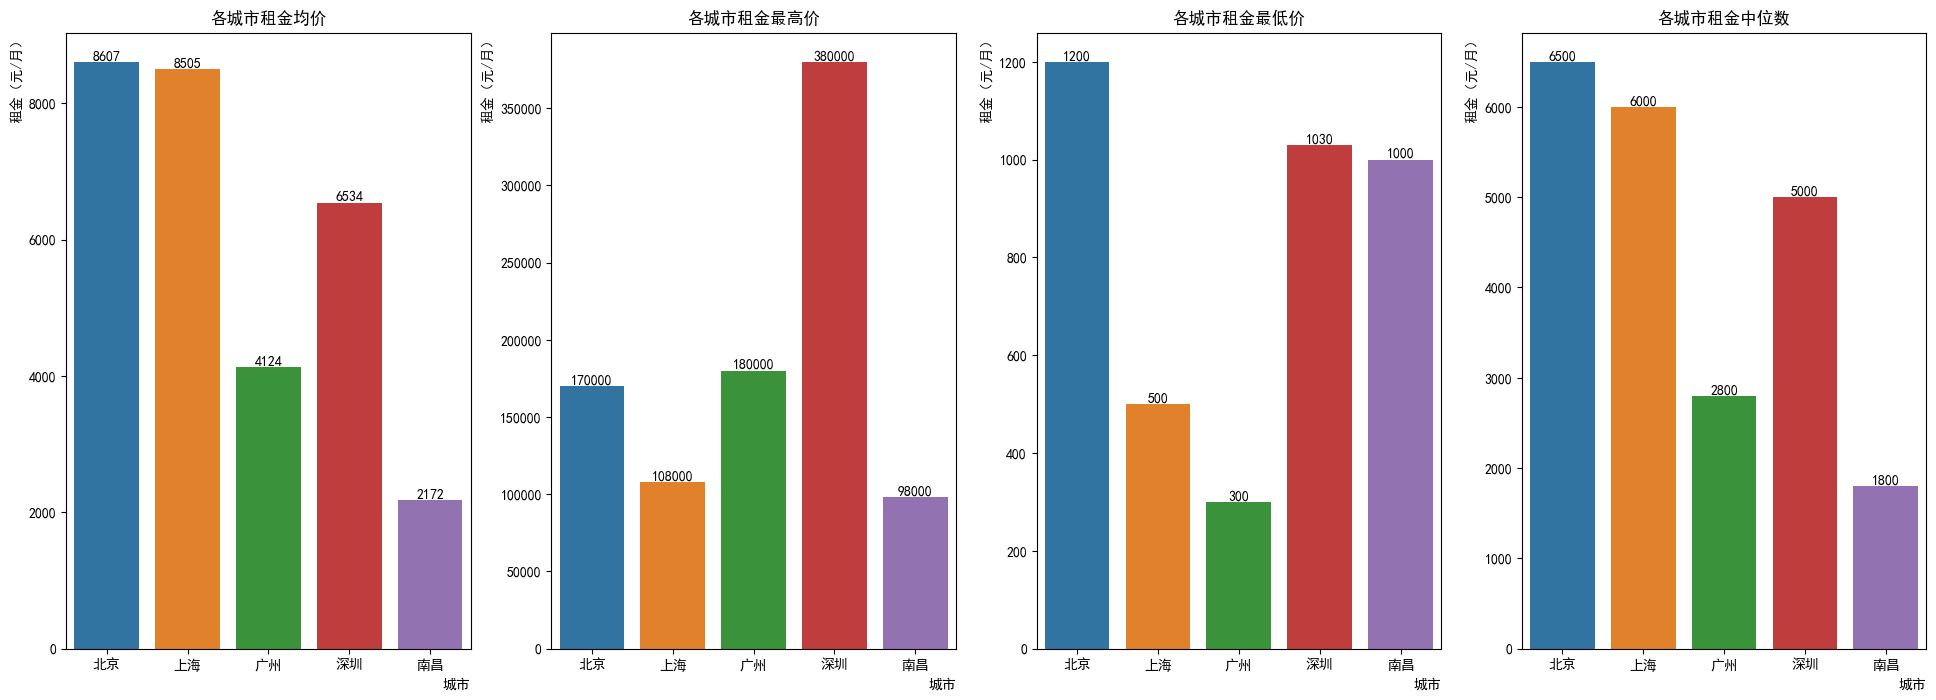

In [479]:
# 绘制柱状图，比较各城市的租金均价、最高价、最低价、中位数
data = [month_price_avg, month_price_max, month_price_min, month_price_median]
plot_avg_max_min_median_comparison(data, '城市', '租金（元/月）')

从条形统计图中可以很直观地看出：

- 各城市租金均价由高到低排序为：北京、上海、深圳、广州、南昌
- 各城市租金最高价由高到低排序为：深圳、广州、北京、上海、南昌
- 各城市租金最低价由高到低排序为：北京、深圳、南昌、上海、广州
- 各城市租金中位数由高到低排序为：北京、上海、深圳、广州、南昌

中位数更能反映一个城市整体房租的情况。

#### 单位面积租金分析

接下来分析各城市单位面积租金的情况，对单位租金的均价、最高价、最低价、中位数进行统计分析：

In [480]:
# 单位面积租金的均价
unit_price_avg = pd.Series({
    '北京': (bj_df['租金'] / bj_df['面积']).mean(),
    '上海': (sh_df['租金'] / sh_df['面积']).mean(),
    '广州': (gz_df['租金'] / gz_df['面积']).mean(),
    '深圳': (sz_df['租金'] / sz_df['面积']).mean(),
    '南昌': (nc_df['租金'] / nc_df['面积']).mean()
}, name='各城市单位面积租金均价')
unit_price_avg

北京    102.072783
上海     99.635658
广州     57.794772
深圳    114.748405
南昌     28.152563
Name: 各城市单位面积租金均价, dtype: float64

In [481]:
# 单位面积租金的最高价
unit_price_max = pd.Series({
    '北京': (bj_df['租金'] / bj_df['面积']).max(),
    '上海': (sh_df['租金'] / sh_df['面积']).max(),
    '广州': (gz_df['租金'] / gz_df['面积']).max(),
    '深圳': (sz_df['租金'] / sz_df['面积']).max(),
    '南昌': (nc_df['租金'] / nc_df['面积']).max()
}, name='各城市单位面积租金最高价')
unit_price_max

北京    364.806867
上海    450.204638
广州    465.116279
深圳    730.769231
南昌    125.000000
Name: 各城市单位面积租金最高价, dtype: float64

In [482]:
# 将南昌异常值去除，只有一个面积为 1500 平方米，租金为 1100 元/月的异常数据
nc_df = nc_df[(nc_df['面积'] != 1500.0) & (nc_df['租金'] != 1100.0)]

# 单位面积租金的最低价
unit_price_min = pd.Series({
    '北京': (bj_df['租金'] / bj_df['面积']).min(),
    '上海': (sh_df['租金'] / sh_df['面积']).min(),
    '广州': (gz_df['租金'] / gz_df['面积']).min(),
    '深圳': (sz_df['租金'] / sz_df['面积']).min(),
    '南昌': (nc_df['租金'] / nc_df['面积']).min()
}, name='各城市单位面积租金最低价')
unit_price_min

北京    12.855414
上海     4.965736
广州     6.153846
深圳    16.863406
南昌     5.357143
Name: 各城市单位面积租金最低价, dtype: float64

In [483]:
# 单位面积租金的中位数
unit_price_median = pd.Series({
    '北京': (bj_df['租金'] / bj_df['面积']).median(),
    '上海': (sh_df['租金'] / sh_df['面积']).median(),
    '广州': (gz_df['租金'] / gz_df['面积']).median(),
    '深圳': (sz_df['租金'] / sz_df['面积']).median(),
    '南昌': (nc_df['租金'] / nc_df['面积']).median()
}, name='各城市单位面积租金中位数')
unit_price_median

北京    95.964027
上海    96.585366
广州    42.666667
深圳    97.727273
南昌    25.017870
Name: 各城市单位面积租金中位数, dtype: float64

根据以上统计结果绘制条形图比较各城市单位面积租金的均值、最大值、最小值、中位数：

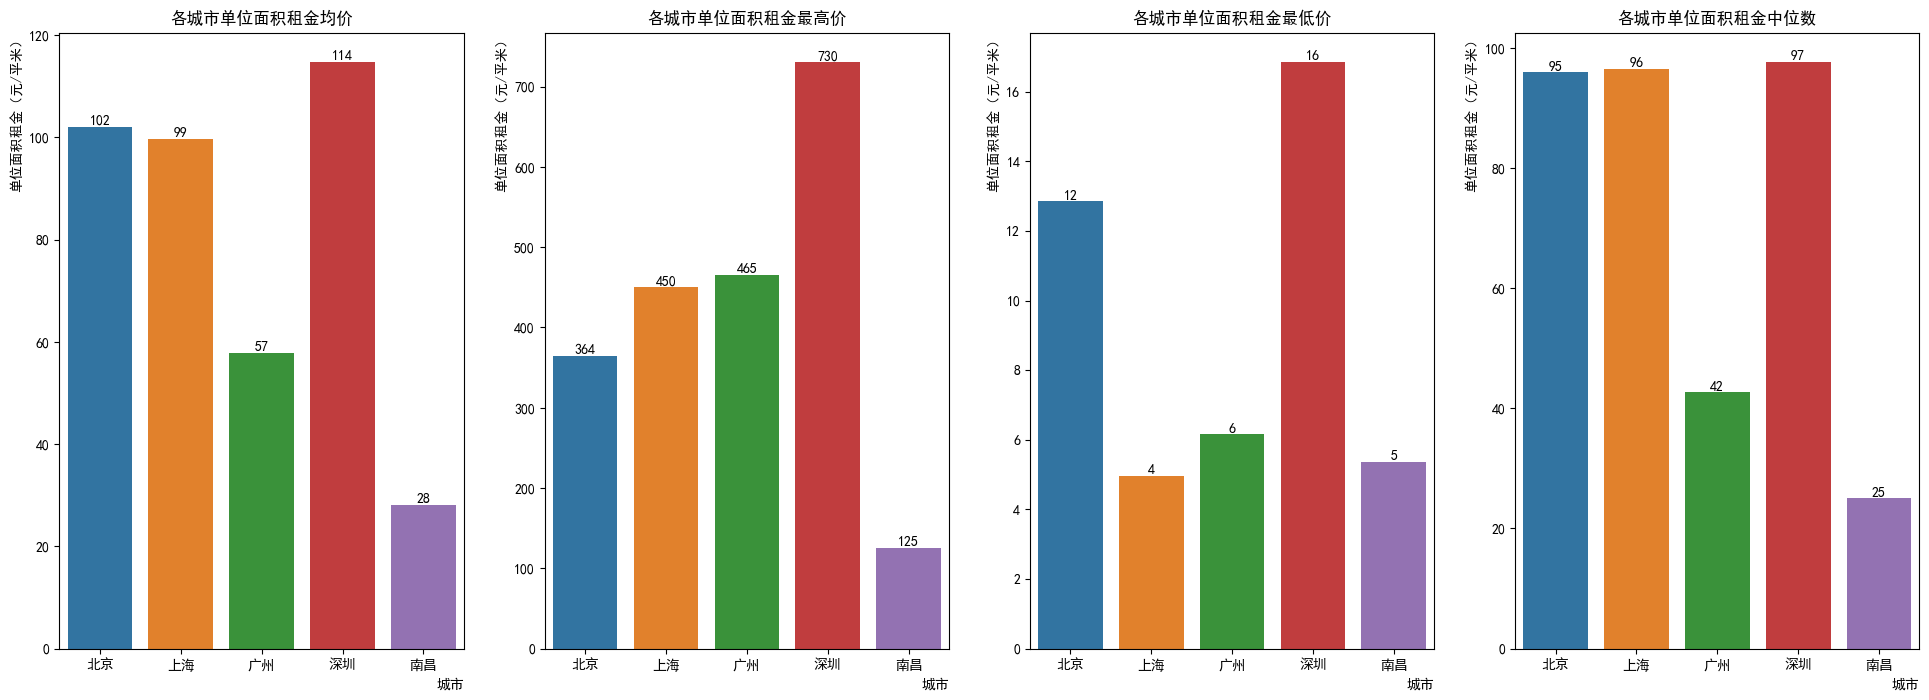

In [484]:
# 绘制柱状图，比较各城市的单位面积租金均价、最高价、最低价、中位数
data = [unit_price_avg, unit_price_max, unit_price_min, unit_price_median]
plot_avg_max_min_median_comparison(data, '城市', '单位面积租金（元/平米）')

从条形统计图中可以很直观地看出：

- 各城市单位面积租金均价由高到低排序为：深圳、北京、上海、广州、南昌
- 各城市单位面积租金最高价由高到低排序为：深圳、广州、上海、北京、南昌
- 各城市单位面积租金最低价由高到低排序为：深圳、北京、广州、南昌、上海
- 各城市单位面积租金中位数由高到低排序为：深圳、上海、北京、广州、南昌

### 不同居室租金情况的比较

下面比较各城市一居室、两居室、三居室的情况，分别比较这几居室租金的均价、最高价、最低价和中位数

#### 一居室

筛选出各城市一居室的租房数据，再对这些房子的租金求均价、最高价、最低价、中位数

对每个城市一居室的房子做如上统计

In [485]:
# 一居室的租金均价
one_room_price_avg = pd.Series({
    '北京': bj_df[
                (bj_df['户型'].str.split('室').str[0] == '1') | \
                (bj_df['户型'].str.split('房间').str[0] == '1')
            ]['租金'].mean(),
    '上海': sh_df[
                (sh_df['户型'].str.split('室').str[0] == '1') | \
                (sh_df['户型'].str.split('房间').str[0] == '1')
            ]['租金'].mean(),
    '广州': gz_df[
                (gz_df['户型'].str.split('室').str[0] == '1') | \
                (gz_df['户型'].str.split('房间').str[0] == '1')
            ]['租金'].mean(),
    '深圳': sz_df[
                (sz_df['户型'].str.split('室').str[0] == '1') | \
                (sz_df['户型'].str.split('房间').str[0] == '1')
            ]['租金'].mean(),
    '南昌': nc_df[
                (nc_df['户型'].str.split('室').str[0] == '1') | \
                (nc_df['户型'].str.split('房间').str[0] == '1')
            ]['租金'].mean()    
}, name='各城市一居室租金均价')
one_room_price_avg

北京    6104.553789
上海    5513.334233
广州    3613.079612
深圳    4053.118680
南昌    1761.339984
Name: 各城市一居室租金均价, dtype: float64

In [486]:
# 一居室的租金最高价
one_room_price_max = pd.Series({
    '北京': bj_df[
                (bj_df['户型'].str.split('室').str[0] == '1') | \
                (bj_df['户型'].str.split('房间').str[0] == '1')
            ]['租金'].max(),
    '上海': sh_df[
                (sh_df['户型'].str.split('室').str[0] == '1') | \
                (sh_df['户型'].str.split('房间').str[0] == '1')
            ]['租金'].max(),
    '广州': gz_df[
                (gz_df['户型'].str.split('室').str[0] == '1') | \
                (gz_df['户型'].str.split('房间').str[0] == '1')
            ]['租金'].max(),
    '深圳': sz_df[
                (sz_df['户型'].str.split('室').str[0] == '1') | \
                (sz_df['户型'].str.split('房间').str[0] == '1')
            ]['租金'].max(),
    '南昌': nc_df[
                (nc_df['户型'].str.split('室').str[0] == '1') | \
                (nc_df['户型'].str.split('房间').str[0] == '1')
            ]['租金'].max()    
}, name='各城市一居室租金最高价')
one_room_price_max

北京    95000.0
上海    24412.0
广州    48000.0
深圳    72000.0
南昌    31200.0
Name: 各城市一居室租金最高价, dtype: float64

In [487]:
# 一居室的租金最低价
one_room_price_min = pd.Series({
    '北京': bj_df[
                (bj_df['户型'].str.split('室').str[0] == '1') | \
                (bj_df['户型'].str.split('房间').str[0] == '1')
            ]['租金'].min(),
    '上海': sh_df[
                (sh_df['户型'].str.split('室').str[0] == '1') | \
                (sh_df['户型'].str.split('房间').str[0] == '1')
            ]['租金'].min(),
    '广州': gz_df[
                (gz_df['户型'].str.split('室').str[0] == '1') | \
                (gz_df['户型'].str.split('房间').str[0] == '1')
            ]['租金'].min(),
    '深圳': sz_df[
                (sz_df['户型'].str.split('室').str[0] == '1') | \
                (sz_df['户型'].str.split('房间').str[0] == '1')
            ]['租金'].min(),
    '南昌': nc_df[
                (nc_df['户型'].str.split('室').str[0] == '1') | \
                (nc_df['户型'].str.split('房间').str[0] == '1')
            ]['租金'].min()    
}, name='各城市一居室租金最低价')
one_room_price_min

北京    1400.0
上海    1250.0
广州     300.0
深圳    1100.0
南昌    1000.0
Name: 各城市一居室租金最低价, dtype: float64

In [488]:
# 一居室的租金中位数
one_room_price_median = pd.Series({
    '北京': bj_df[
                (bj_df['户型'].str.split('室').str[0] == '1') | \
                (bj_df['户型'].str.split('房间').str[0] == '1')
            ]['租金'].median(),
    '上海': sh_df[
                (sh_df['户型'].str.split('室').str[0] == '1') | \
                (sh_df['户型'].str.split('房间').str[0] == '1')
            ]['租金'].median(),
    '广州': gz_df[
                (gz_df['户型'].str.split('室').str[0] == '1') | \
                (gz_df['户型'].str.split('房间').str[0] == '1')
            ]['租金'].median(),
    '深圳': sz_df[
                (sz_df['户型'].str.split('室').str[0] == '1') | \
                (sz_df['户型'].str.split('房间').str[0] == '1')
            ]['租金'].median(),
    '南昌': nc_df[
                (nc_df['户型'].str.split('室').str[0] == '1') | \
                (nc_df['户型'].str.split('房间').str[0] == '1')
            ]['租金'].median()    
}, name='各城市一居室租金中位数')
one_room_price_median

北京    5830.0
上海    5190.0
广州    2500.0
深圳    3560.0
南昌    1600.0
Name: 各城市一居室租金中位数, dtype: float64

根据以上统计结果绘制条形图比较各城市一居室房屋租金的均价、最高价、最低价、中位数：

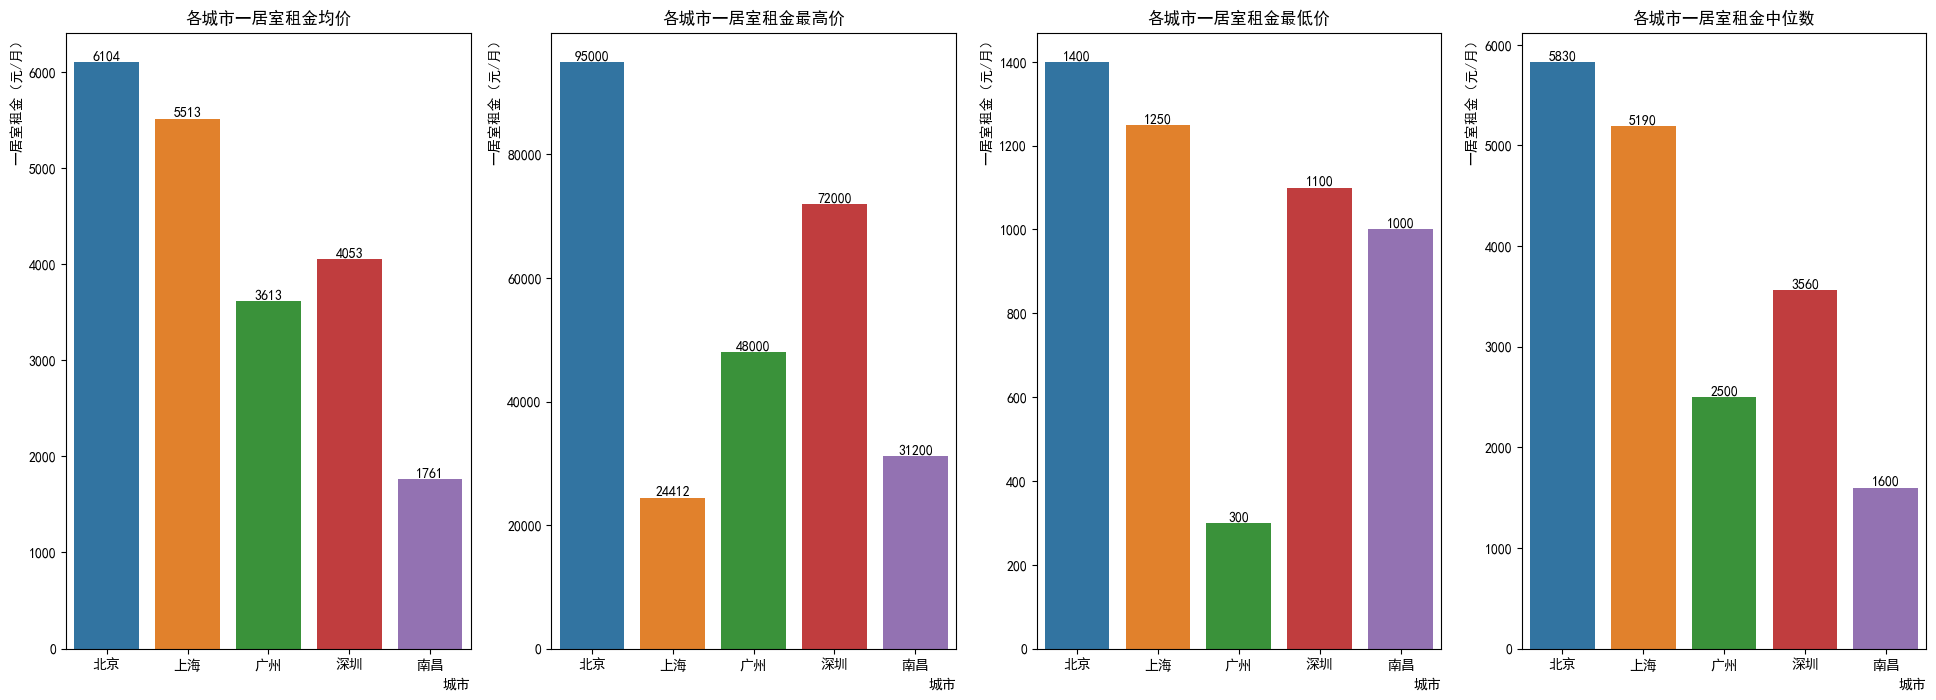

In [489]:
# 绘制柱状图，比较各城市的一居室租金均价、最高价、最低价、中位数
data = [one_room_price_avg, one_room_price_max, one_room_price_min, one_room_price_median]
plot_avg_max_min_median_comparison(data, '城市', '一居室租金（元/月）')

根据以上分析可以看出：

- 各城市一居室租金均价由高到低排序：北京、上海、深圳、广州、南昌
- 各城市一居室租金最高价由高到低排序：北京、深圳、广州、南昌、上海
- 各城市一居室租金最低价由高到低排序：北京、上海、深圳、南昌、广州
- 各城市一居室租金中位数由高到低排序：北京、上海、深圳、广州、南昌

#### 两居室

筛选出各城市两居室的租房数据，再对这些房子的租金求均价、最高价、最低价、中位数

对每个城市两居室的房子做如上统计

In [490]:
# 两居室的租金均价
two_room_price_avg = pd.Series({
    '北京': bj_df[
                (bj_df['户型'].str.split('室').str[0] == '2') | \
                (bj_df['户型'].str.split('房间').str[0] == '2')
            ]['租金'].mean(),
    '上海': sh_df[
                (sh_df['户型'].str.split('室').str[0] == '2') | \
                (sh_df['户型'].str.split('房间').str[0] == '2')
            ]['租金'].mean(),
    '广州': gz_df[
                (gz_df['户型'].str.split('室').str[0] == '2') | \
                (gz_df['户型'].str.split('房间').str[0] == '2')
            ]['租金'].mean(),
    '深圳': sz_df[
                (sz_df['户型'].str.split('室').str[0] == '2') | \
                (sz_df['户型'].str.split('房间').str[0] == '2')
            ]['租金'].mean(),
    '南昌': nc_df[
                (nc_df['户型'].str.split('室').str[0] == '2') | \
                (nc_df['户型'].str.split('房间').str[0] == '2')
            ]['租金'].mean()    
}, name='各城市两居室租金均价')
two_room_price_avg

北京    7174.681373
上海    6938.271265
广州    3002.168493
深圳    6894.603018
南昌    1941.994324
Name: 各城市两居室租金均价, dtype: float64

In [491]:
# 两居室的租金最高价
two_room_price_max = pd.Series({
    '北京': bj_df[
                (bj_df['户型'].str.split('室').str[0] == '2') | \
                (bj_df['户型'].str.split('房间').str[0] == '2')
            ]['租金'].max(),
    '上海': sh_df[
                (sh_df['户型'].str.split('室').str[0] == '2') | \
                (sh_df['户型'].str.split('房间').str[0] == '2')
            ]['租金'].max(),
    '广州': gz_df[
                (gz_df['户型'].str.split('室').str[0] == '2') | \
                (gz_df['户型'].str.split('房间').str[0] == '2')
            ]['租金'].max(),
    '深圳': sz_df[
                (sz_df['户型'].str.split('室').str[0] == '2') | \
                (sz_df['户型'].str.split('房间').str[0] == '2')
            ]['租金'].max(),
    '南昌': nc_df[
                (nc_df['户型'].str.split('室').str[0] == '2') | \
                (nc_df['户型'].str.split('房间').str[0] == '2')
            ]['租金'].max()    
}, name='各城市两居室租金最高价')
two_room_price_max

北京    33700.0
上海    55000.0
广州    15999.0
深圳    35000.0
南昌    13200.0
Name: 各城市两居室租金最高价, dtype: float64

In [492]:
# 两居室的租金最低价
two_room_price_min = pd.Series({
    '北京': bj_df[
                (bj_df['户型'].str.split('室').str[0] == '2') | \
                (bj_df['户型'].str.split('房间').str[0] == '2')
            ]['租金'].min(),
    '上海': sh_df[
                (sh_df['户型'].str.split('室').str[0] == '2') | \
                (sh_df['户型'].str.split('房间').str[0] == '2')
            ]['租金'].min(),
    '广州': gz_df[
                (gz_df['户型'].str.split('室').str[0] == '2') | \
                (gz_df['户型'].str.split('房间').str[0] == '2')
            ]['租金'].min(),
    '深圳': sz_df[
                (sz_df['户型'].str.split('室').str[0] == '2') | \
                (sz_df['户型'].str.split('房间').str[0] == '2')
            ]['租金'].min(),
    '南昌': nc_df[
                (nc_df['户型'].str.split('室').str[0] == '2') | \
                (nc_df['户型'].str.split('房间').str[0] == '2')
            ]['租金'].min()    
}, name='各城市两居室租金最低价')
two_room_price_min

北京    1200.0
上海     500.0
广州     800.0
深圳    1600.0
南昌    1000.0
Name: 各城市两居室租金最低价, dtype: float64

In [493]:
# 两居室的租金中位数
two_room_price_median = pd.Series({
    '北京': bj_df[
                (bj_df['户型'].str.split('室').str[0] == '2') | \
                (bj_df['户型'].str.split('房间').str[0] == '2')
            ]['租金'].median(),
    '上海': sh_df[
                (sh_df['户型'].str.split('室').str[0] == '2') | \
                (sh_df['户型'].str.split('房间').str[0] == '2')
            ]['租金'].median(),
    '广州': gz_df[
                (gz_df['户型'].str.split('室').str[0] == '2') | \
                (gz_df['户型'].str.split('房间').str[0] == '2')
            ]['租金'].median(),
    '深圳': sz_df[
                (sz_df['户型'].str.split('室').str[0] == '2') | \
                (sz_df['户型'].str.split('房间').str[0] == '2')
            ]['租金'].median(),
    '南昌': nc_df[
                (nc_df['户型'].str.split('室').str[0] == '2') | \
                (nc_df['户型'].str.split('房间').str[0] == '2')
            ]['租金'].median()    
}, name='各城市两居室租金中位数')
two_room_price_median

北京    6290.0
上海    6000.0
广州    2800.0
深圳    6300.0
南昌    1700.0
Name: 各城市两居室租金中位数, dtype: float64

根据以上统计结果绘制条形图比较各城市两居室房屋租金的均价、最高价、最低价、中位数：

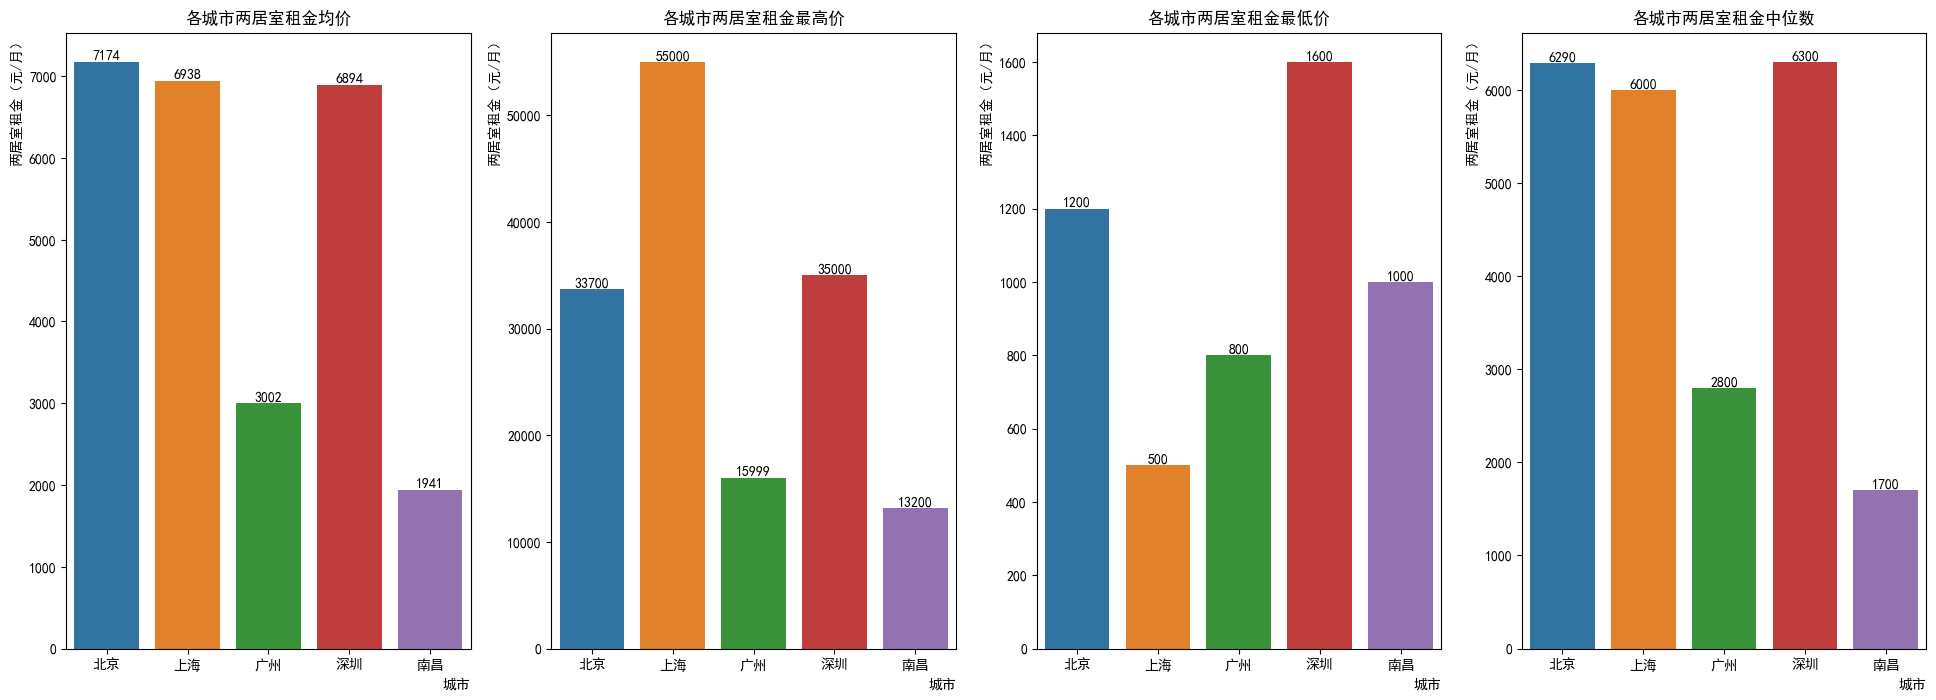

In [494]:
# 绘制柱状图，比较各城市的两居室租金均价、最高价、最低价、中位数
data = [two_room_price_avg, two_room_price_max, two_room_price_min, two_room_price_median]
plot_avg_max_min_median_comparison(data, '城市', '两居室租金（元/月）')

根据以上分析可以看出：

- 各城市两居室租金均价由高到低排序：北京、上海、深圳、广州、南昌
- 各城市两居室租金最高价由高到低排序：上海、深圳、北京、广州、南昌
- 各城市两居室租金最低价由高到低排序：深圳、北京、南昌、广州、上海
- 各城市两居室租金中位数由高到低排序：深圳、北京、上海、广州、南昌

#### 三居室

筛选出各城市三居室的租房数据，再对这些房子的租金求均价、最高价、最低价、中位数

对每个城市三居室的房子做如上统计

In [495]:
# 三居室的租金均价
three_room_price_avg = pd.Series({
    '北京': bj_df[
                (bj_df['户型'].str.split('室').str[0] == '3') | \
                (bj_df['户型'].str.split('房间').str[0] == '3')
            ]['租金'].mean(),
    '上海': sh_df[
                (sh_df['户型'].str.split('室').str[0] == '3') | \
                (sh_df['户型'].str.split('房间').str[0] == '3')
            ]['租金'].mean(),
    '广州': gz_df[
                (gz_df['户型'].str.split('室').str[0] == '3') | \
                (gz_df['户型'].str.split('房间').str[0] == '3')
            ]['租金'].mean(),
    '深圳': sz_df[
                (sz_df['户型'].str.split('室').str[0] == '3') | \
                (sz_df['户型'].str.split('房间').str[0] == '3')
            ]['租金'].mean(),
    '南昌': nc_df[
                (nc_df['户型'].str.split('室').str[0] == '3') | \
                (nc_df['户型'].str.split('房间').str[0] == '3')
            ]['租金'].mean()    
}, name='各城市三居室租金均价')
three_room_price_avg

北京    11365.311340
上海    11209.236522
广州     3756.759162
深圳     7231.646194
南昌     2402.466005
Name: 各城市三居室租金均价, dtype: float64

In [496]:
# 三居室的租金最高价
three_room_price_max = pd.Series({
    '北京': bj_df[
                (bj_df['户型'].str.split('室').str[0] == '3') | \
                (bj_df['户型'].str.split('房间').str[0] == '3')
            ]['租金'].max(),
    '上海': sh_df[
                (sh_df['户型'].str.split('室').str[0] == '3') | \
                (sh_df['户型'].str.split('房间').str[0] == '3')
            ]['租金'].max(),
    '广州': gz_df[
                (gz_df['户型'].str.split('室').str[0] == '3') | \
                (gz_df['户型'].str.split('房间').str[0] == '3')
            ]['租金'].max(),
    '深圳': sz_df[
                (sz_df['户型'].str.split('室').str[0] == '3') | \
                (sz_df['户型'].str.split('房间').str[0] == '3')
            ]['租金'].max(),
    '南昌': nc_df[
                (nc_df['户型'].str.split('室').str[0] == '3') | \
                (nc_df['户型'].str.split('房间').str[0] == '3')
            ]['租金'].max()    
}, name='各城市三居室租金最高价')
three_room_price_max

北京    84000.0
上海    78000.0
广州    80000.0
深圳    80000.0
南昌    10000.0
Name: 各城市三居室租金最高价, dtype: float64

In [497]:
# 三居室的租金最低价
three_room_price_min = pd.Series({
    '北京': bj_df[
                (bj_df['户型'].str.split('室').str[0] == '3') | \
                (bj_df['户型'].str.split('房间').str[0] == '3')
            ]['租金'].min(),
    '上海': sh_df[
                (sh_df['户型'].str.split('室').str[0] == '3') | \
                (sh_df['户型'].str.split('房间').str[0] == '3')
            ]['租金'].min(),
    '广州': gz_df[
                (gz_df['户型'].str.split('室').str[0] == '3') | \
                (gz_df['户型'].str.split('房间').str[0] == '3')
            ]['租金'].min(),
    '深圳': sz_df[
                (sz_df['户型'].str.split('室').str[0] == '3') | \
                (sz_df['户型'].str.split('房间').str[0] == '3')
            ]['租金'].min(),
    '南昌': nc_df[
                (nc_df['户型'].str.split('室').str[0] == '3') | \
                (nc_df['户型'].str.split('房间').str[0] == '3')
            ]['租金'].min()    
}, name='各城市三居室租金最低价')
three_room_price_min

北京    1700.0
上海    1900.0
广州     800.0
深圳    1490.0
南昌    1000.0
Name: 各城市三居室租金最低价, dtype: float64

In [498]:
# 三居室的租金中位数
three_room_price_median = pd.Series({
    '北京': bj_df[
                (bj_df['户型'].str.split('室').str[0] == '3') | \
                (bj_df['户型'].str.split('房间').str[0] == '3')
            ]['租金'].median(),
    '上海': sh_df[
                (sh_df['户型'].str.split('室').str[0] == '3') | \
                (sh_df['户型'].str.split('房间').str[0] == '3')
            ]['租金'].median(),
    '广州': gz_df[
                (gz_df['户型'].str.split('室').str[0] == '3') | \
                (gz_df['户型'].str.split('房间').str[0] == '3')
            ]['租金'].median(),
    '深圳': sz_df[
                (sz_df['户型'].str.split('室').str[0] == '3') | \
                (sz_df['户型'].str.split('房间').str[0] == '3')
            ]['租金'].median(),
    '南昌': nc_df[
                (nc_df['户型'].str.split('室').str[0] == '3') | \
                (nc_df['户型'].str.split('房间').str[0] == '3')
            ]['租金'].median()    
}, name='各城市三居室租金中位数')
three_room_price_median

北京     8500.0
上海    11000.0
广州     2800.0
深圳     6500.0
南昌     2000.0
Name: 各城市三居室租金中位数, dtype: float64

根据以上统计结果绘制条形图比较各城市三居室房屋租金的均价、最高价、最低价、中位数：

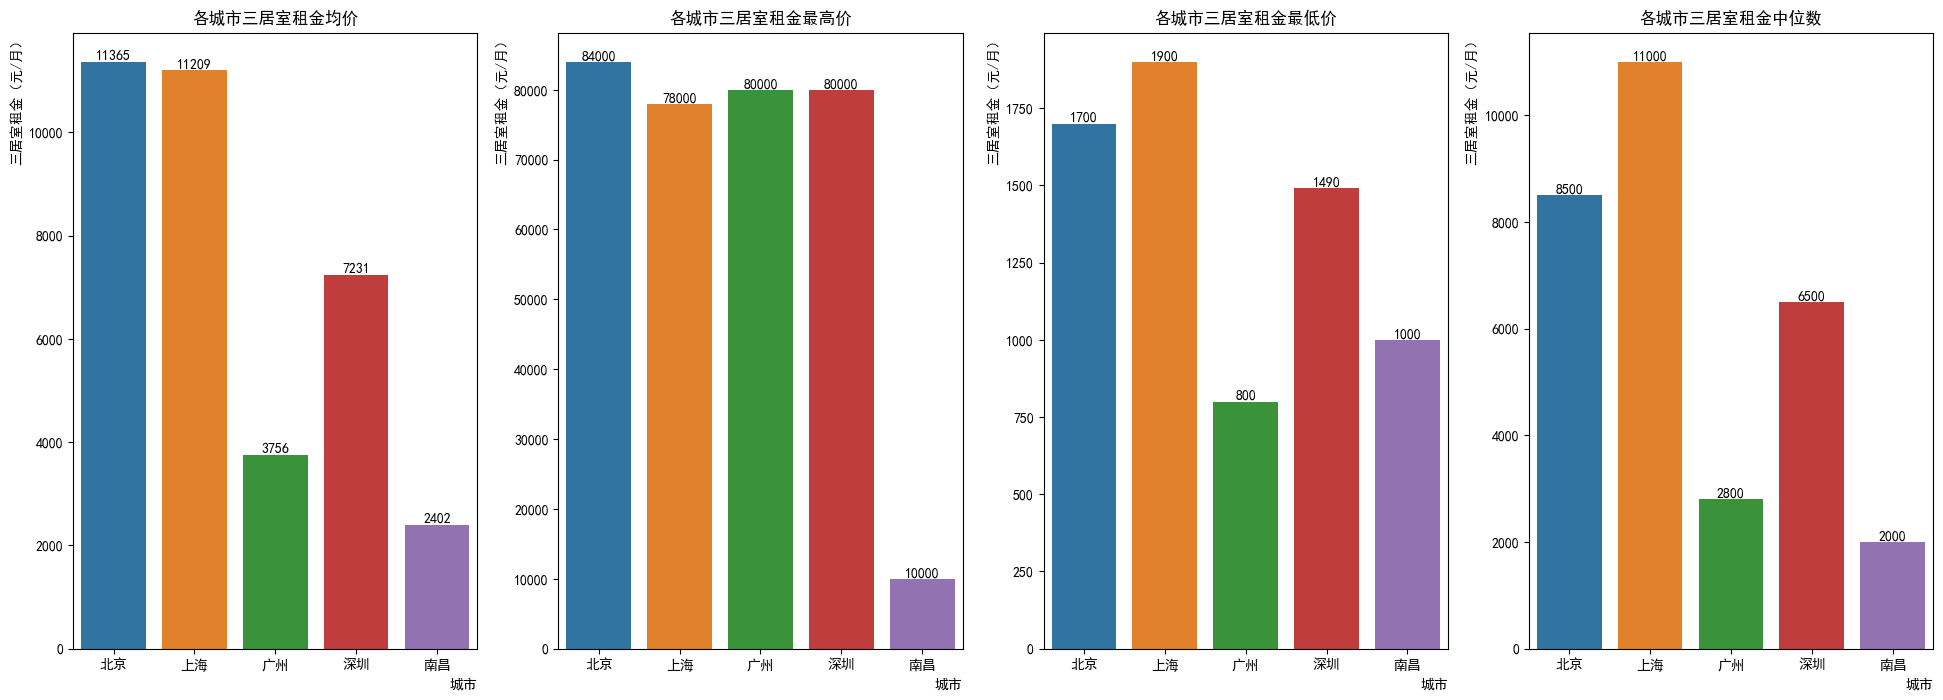

In [499]:
# 绘制柱状图，比较各城市的三居室租金均价、最高价、最低价、中位数
data = [three_room_price_avg, three_room_price_max, three_room_price_min, three_room_price_median]
plot_avg_max_min_median_comparison(data, '城市', '三居室租金（元/月）')

根据以上分析可以看出：

- 各城市三居室租金均价由高到低排序：北京、上海、深圳、广州、南昌
- 各城市三居室租金最高价由高到低排序：北京、广州、深圳、上海、南昌
- 各城市三居室租金最低价由高到低排序：上海、北京、深圳、广州、南昌
- 各城市三居室租金中位数由高到低排序：上海、北京、深圳、广州、南昌

我们还可以来看一下各个城市各居室租金的中位数之间的比较：

In [500]:
# 北京一、二、三居室的租金中位数
bj_room_price_median = pd.Series({
    '一居室': bj_df[
                (bj_df['户型'].str.split('室').str[0] == '1') | \
                (bj_df['户型'].str.split('房间').str[0] == '1')
            ]['租金'].median(),
    '两居室': bj_df[
                (bj_df['户型'].str.split('室').str[0] == '2') | \
                (bj_df['户型'].str.split('房间').str[0] == '2')
            ]['租金'].median(),
    '三居室': bj_df[
                (bj_df['户型'].str.split('室').str[0] == '3') | \
                (bj_df['户型'].str.split('房间').str[0] == '3')
            ]['租金'].median()
}, name='北京一、二、三居室租金中位数')
bj_room_price_median

一居室    5830.0
两居室    6290.0
三居室    8500.0
Name: 北京一、二、三居室租金中位数, dtype: float64

In [501]:
# 上海一、二、三居室的租金中位数
sh_room_price_median = pd.Series({
    '一居室': sh_df[
                (sh_df['户型'].str.split('室').str[0] == '1') | \
                (sh_df['户型'].str.split('房间').str[0] == '1')
            ]['租金'].median(),
    '两居室': sh_df[
                (sh_df['户型'].str.split('室').str[0] == '2') | \
                (sh_df['户型'].str.split('房间').str[0] == '2')
            ]['租金'].median(),
    '三居室': sh_df[
                (sh_df['户型'].str.split('室').str[0] == '3') | \
                (sh_df['户型'].str.split('房间').str[0] == '3')
            ]['租金'].median()
}, name='上海一、二、三居室租金中位数')
sh_room_price_median

一居室     5190.0
两居室     6000.0
三居室    11000.0
Name: 上海一、二、三居室租金中位数, dtype: float64

In [502]:
# 广州一、二、三居室的租金中位数
gz_room_price_median = pd.Series({
    '一居室': gz_df[
                (gz_df['户型'].str.split('室').str[0] == '1') | \
                (gz_df['户型'].str.split('房间').str[0] == '1')
            ]['租金'].median(),
    '两居室': gz_df[
                (gz_df['户型'].str.split('室').str[0] == '2') | \
                (gz_df['户型'].str.split('房间').str[0] == '2')
            ]['租金'].median(),
    '三居室': gz_df[
                (gz_df['户型'].str.split('室').str[0] == '3') | \
                (gz_df['户型'].str.split('房间').str[0] == '3')
            ]['租金'].median()
}, name='广州一、二、三居室租金中位数')
gz_room_price_median

一居室    2500.0
两居室    2800.0
三居室    2800.0
Name: 广州一、二、三居室租金中位数, dtype: float64

In [503]:
# 深圳一、二、三居室的租金中位数
sz_room_price_median = pd.Series({
    '一居室': sz_df[
                (sz_df['户型'].str.split('室').str[0] == '1') | \
                (sz_df['户型'].str.split('房间').str[0] == '1')
            ]['租金'].median(),
    '两居室': sz_df[
                (sz_df['户型'].str.split('室').str[0] == '2') | \
                (sz_df['户型'].str.split('房间').str[0] == '2')
            ]['租金'].median(),
    '三居室': sz_df[
                (sz_df['户型'].str.split('室').str[0] == '3') | \
                (sz_df['户型'].str.split('房间').str[0] == '3')
            ]['租金'].median()
}, name='深圳一、二、三居室租金中位数')
sz_room_price_median

一居室    3560.0
两居室    6300.0
三居室    6500.0
Name: 深圳一、二、三居室租金中位数, dtype: float64

In [504]:
# 南昌一、二、三居室的租金中位数
nc_room_price_median = pd.Series({
    '一居室': nc_df[
                (nc_df['户型'].str.split('室').str[0] == '1') | \
                (nc_df['户型'].str.split('房间').str[0] == '1')
            ]['租金'].median(),
    '两居室': nc_df[
                (nc_df['户型'].str.split('室').str[0] == '2') | \
                (nc_df['户型'].str.split('房间').str[0] == '2')
            ]['租金'].median(),
    '三居室': nc_df[
                (nc_df['户型'].str.split('室').str[0] == '3') | \
                (nc_df['户型'].str.split('房间').str[0] == '3')
            ]['租金'].median()
}, name='南昌一、二、三居室租金中位数')
nc_room_price_median

一居室    1600.0
两居室    1700.0
三居室    2000.0
Name: 南昌一、二、三居室租金中位数, dtype: float64

根据以上各城市一、二、三居室的统计信息绘制折线图比较各城市三种居室租金中位数之间的关系：

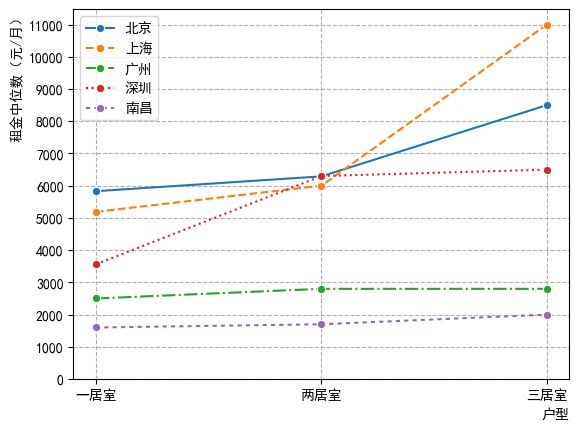

In [505]:
# 创建画布
plt.figure()

# 绘制北京一、二、三居室的租金中位数折线图
sns.lineplot(x=bj_room_price_median.index,
             y=bj_room_price_median.values,
             marker='o',
             linestyle='-',
             label='北京')

# 绘制上海一、二、三居室的租金中位数折线图
sns.lineplot(x=sh_room_price_median.index,
             y=sh_room_price_median.values,
             marker='o',
             linestyle='--',
             label='上海')

# 绘制广州一、二、三居室的租金中位数折线图
sns.lineplot(x=gz_room_price_median.index,
             y=gz_room_price_median.values,
             marker='o',
             linestyle='-.',
             label='广州')

# 绘制深圳一、二、三居室的租金中位数折线图
sns.lineplot(x=sz_room_price_median.index,
             y=sz_room_price_median.values,
             marker='o',
             linestyle=':',
             label='深圳')

# 绘制南昌一、二、三居室的租金中位数折线图
sns.lineplot(x=nc_room_price_median.index,
             y=nc_room_price_median.values,
             marker='o',
             linestyle=(0, (2, 2)),
             label='南昌')

# 设置坐标轴标签
plt.xlabel('户型', loc='right')
plt.ylabel('租金中位数（元/月）', loc='top')

# 设置坐标轴刻度
plt.yticks(range(0, 12000, 1000))

# 设置网格线
plt.grid(linestyle='--')

# 展示图形
plt.show()

租金中位数与居室的关系，由以上分析可以看出：

- 北京、上海、深圳的租金中位数随着居室的增加而增加较为明显
- 广州、南昌的租金中位数随着居室的增加变化较为平稳

### 五个城市各板块房租均价情况分析

下面对每个城市各板块的租金均价情况进行分析

先将将每个城市的租房信息按照板块分组，再对每个板块内的租金求均值即可得到每个板块的租金均价

根据每个板块的租金均价绘制折线图比较各个板块均价的关系

#### 北京各板块租金均价情况

先求得每个板块的租金均价，并按照均价对板块进行排序，以便了解租金由高到低分别是哪些板块

In [506]:
# 北京各板块的租金均价，并按照均价从高到低排序
bj_block_price_avg = bj_df.groupby('板块')['租金'].mean().sort_values(ascending=False)
bj_block_price_avg.head()

板块
朝阳公园     34482.627119
中央别墅区    29631.081081
官园       26327.142857
魏公村      25000.000000
五道口      24601.590909
Name: 租金, dtype: float64

然后根据不同板块的均价情况绘制折线图

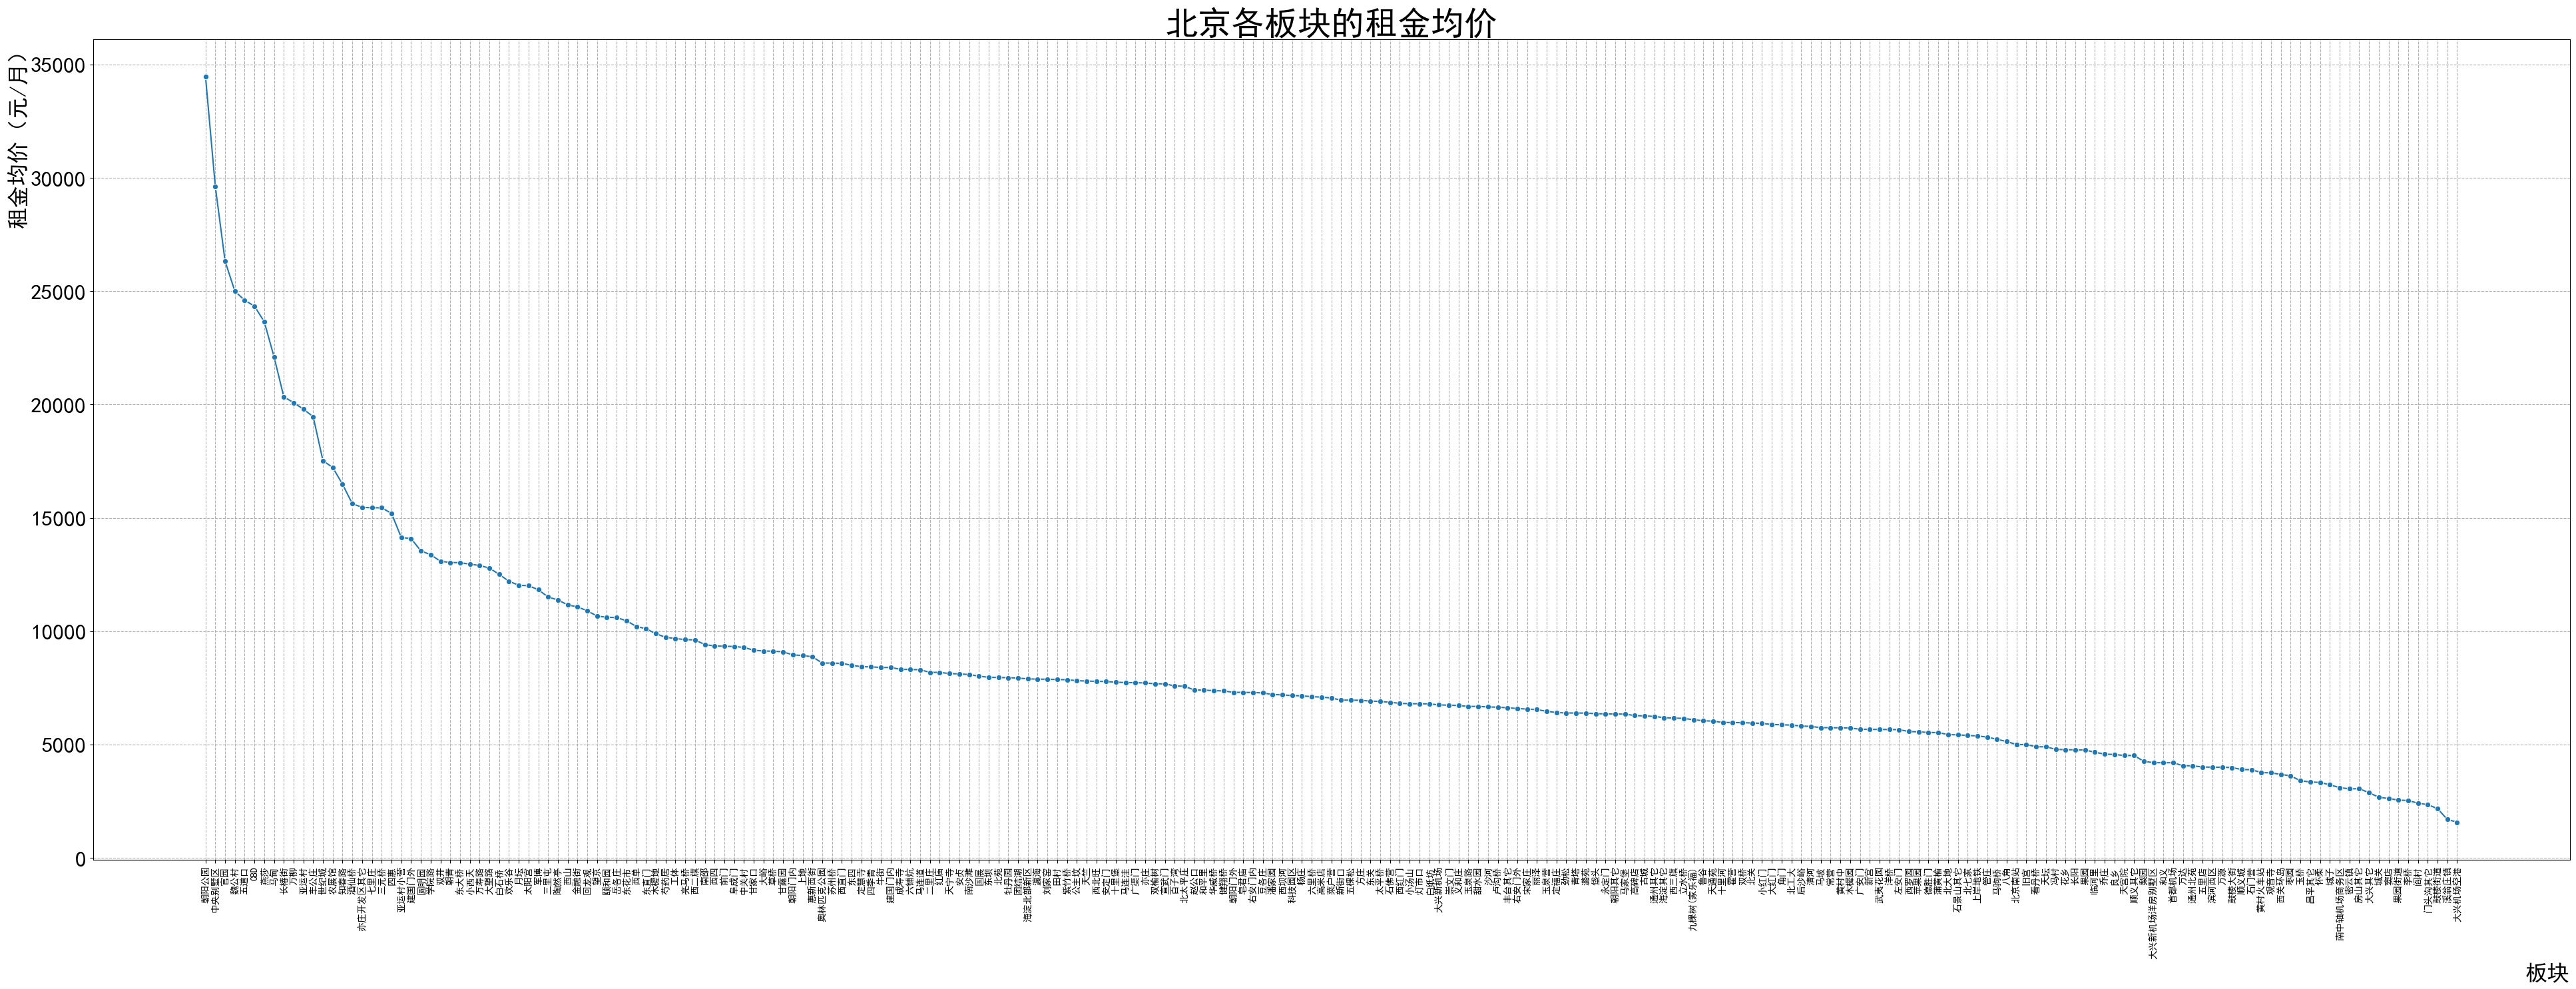

In [507]:
# 创建画布
plt.figure(figsize=(48, 16))

# 绘制北京各板块的租金均价折线图
sns.lineplot(x=bj_block_price_avg.index,
             y=bj_block_price_avg.values,
             marker='o',
             linestyle='-')

# 设置坐标轴标签
plt.xlabel('板块', loc='right', fontsize=24)
plt.ylabel('租金均价（元/月）', loc='top', fontsize=24)

# 设置坐标轴刻度
plt.yticks(fontsize=24)
plt.xticks(rotation=90)

# 设置标题
plt.title('北京各板块的租金均价', fontsize=36)

# 设置网格
plt.grid(linestyle='--')


# 展示图形
plt.show()

由于板块较多，显示过于密集不便观察，这里特别取出租金均价前 20 和 后 20 的板块来观察：

为了提高代码的复用性，将绘制租金均价前 20 和后 20 的板块封装成为两个函数

In [508]:
def plot_block_price_avg(data: list, head_tail: str, items_num: int, xlabel: str, ylabel: str, title: str) -> None:
    # 创建画布
    plt.figure()

    # 绘制各板块的租金均价折线图
    if head_tail == 'head':
        sns.lineplot(x=data.head(items_num).index,
                y=data.head(items_num).values,
                marker='o',
                linestyle='-')
    elif head_tail == 'tail':
        sns.lineplot(x=data.tail(items_num).index,
                    y=data.tail(items_num).values,
                    marker='o',
                    linestyle='-')

    # 设置坐标轴标签
    plt.xlabel(xlabel, loc='right')
    plt.ylabel(ylabel, loc='top')

    # 设置坐标轴刻度
    plt.yticks()
    plt.xticks(rotation=90)

    # 设置标题
    plt.title(title)

    # 设置网格
    plt.grid(linestyle='--')

    # 展示图形
    plt.show()

北京租金均价前 20 的板块：

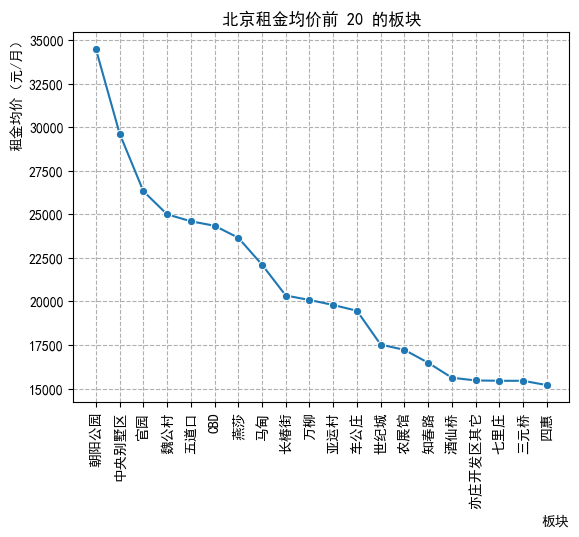

In [509]:
plot_block_price_avg(bj_block_price_avg, 'head', 20, '板块', '租金均价（元/月）', '北京租金均价前 20 的板块')

北京租金均价后 20 个板块：

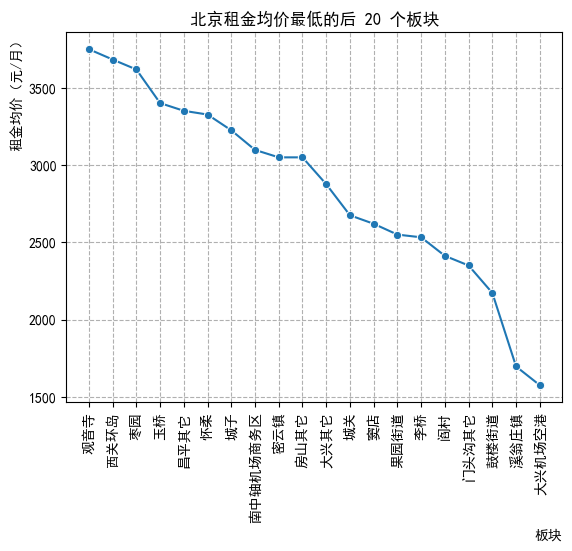

In [510]:
plot_block_price_avg(bj_block_price_avg, 'tail', 20, '板块', '租金均价（元/月）', '北京租金均价最低的后 20 个板块')

之后各个城市的板块租金均价情况也仅展示前 20 与后 20 的情况。

#### 上海各板块租金均价情况

先求得每个板块的租金均价，并按照均价对板块进行排序，以便了解租金由高到低分别是哪些板块

In [511]:
# 上海各板块的租金均价，并按照均价从高到低排序
sh_block_price_avg = sh_df.groupby('板块')['租金'].mean().sort_values(ascending=False)
sh_block_price_avg.head()

板块
陆家嘴     47278.270968
黄浦滨江    41010.000000
赵巷      31172.967033
新天地     30500.000000
徐汇滨江    28454.448276
Name: 租金, dtype: float64

上海租金均价前 20 的板块：

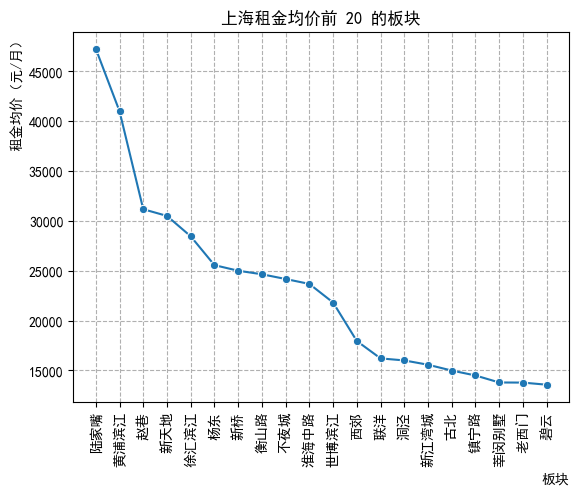

In [512]:
plot_block_price_avg(sh_block_price_avg, 'head', 20, '板块', '租金均价（元/月）', '上海租金均价前 20 的板块')

租金均价后 20 的板块：

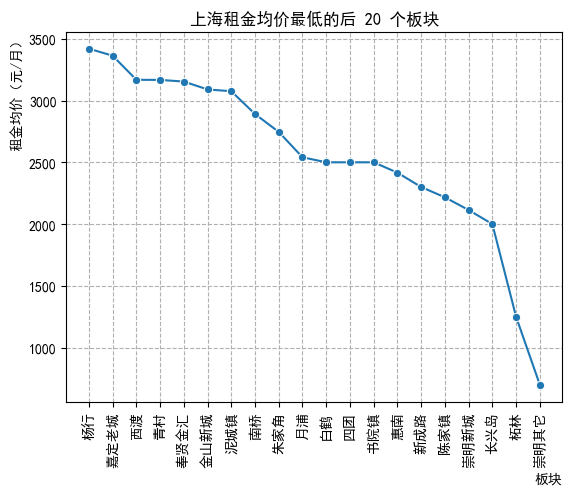

In [513]:
plot_block_price_avg(sh_block_price_avg, 'tail', 20, '板块', '租金均价（元/月）', '上海租金均价最低的后 20 个板块')

#### 广州各板块租金均价情况

先求得每个板块的租金均价，并按照均价对板块进行排序，以便了解租金由高到低分别是哪些板块

In [514]:
# 广州各板块的租金均价，并按照均价从高到低排序
gz_block_price_avg = gz_df.groupby('板块')['租金'].mean().sort_values(ascending=False)
gz_block_price_avg.head()

板块
二沙岛      32000.000000
万胜围      23030.972973
珠江新城中    21774.464286
龙口西      17589.600000
华南碧桂园    17316.666667
Name: 租金, dtype: float64

广州租金均价前 20 的板块：

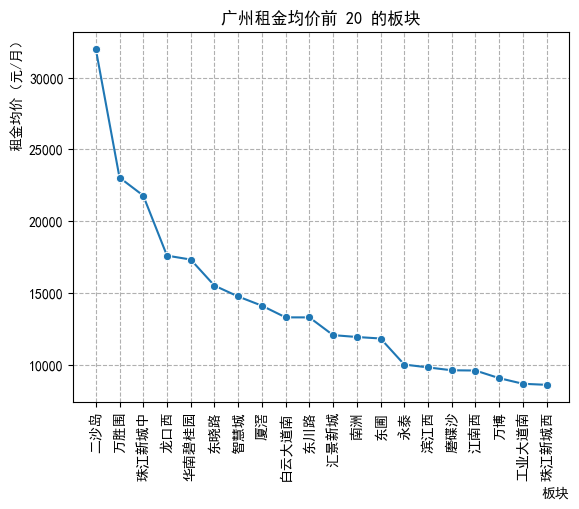

In [515]:
plot_block_price_avg(gz_block_price_avg, 'head', 20, '板块', '租金均价（元/月）', '广州租金均价前 20 的板块')

广州租金后 20 的板块：

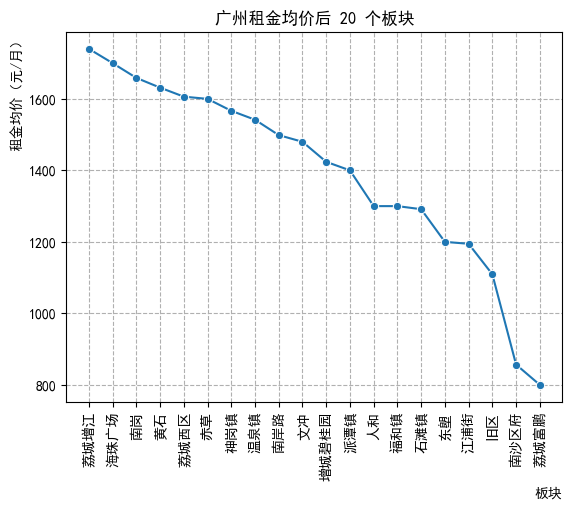

In [516]:
plot_block_price_avg(gz_block_price_avg, 'tail', 20, '板块', '租金均价（元/月）', '广州租金均价后 20 个板块')

#### 深圳各板块租金均价情况

先求得每个板块的租金均价，并按照均价对板块进行排序，以便了解租金由高到低分别是哪些板块

In [517]:
# 深圳各板块的租金均价，并按照均价从高到低排序
sz_block_price_avg = sz_df.groupby('板块')['租金'].mean().sort_values(ascending=False)
sz_block_price_avg.head()

板块
深圳湾    32019.729730
曦城     20285.714286
红树湾    16810.344828
蛇口     16760.649231
黄木岗    16666.666667
Name: 租金, dtype: float64

深圳租金均价前 20 的板块：

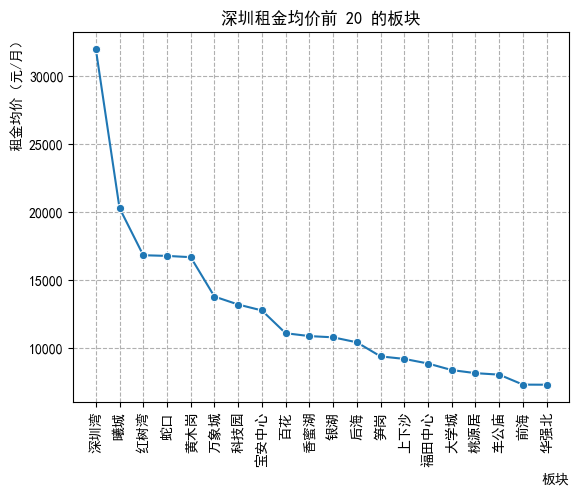

In [518]:
plot_block_price_avg(sz_block_price_avg, 'head', 20, '板块', '租金均价（元/月）', '深圳租金均价前 20 的板块')

深圳租金均价后 20 的板块：

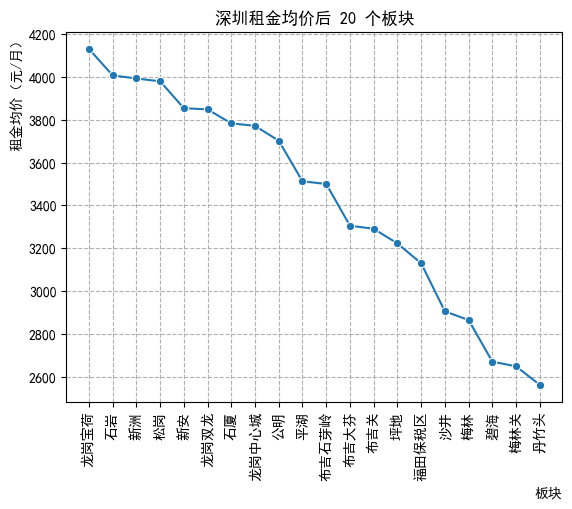

In [519]:
plot_block_price_avg(sz_block_price_avg, 'tail', 20, '板块', '租金均价（元/月）', '深圳租金均价后 20 个板块')

#### 南昌各板块租金均价情况

先求得每个板块的租金均价，并按照均价对板块进行排序，以便了解租金由高到低分别是哪些板块

In [520]:
# 南昌各板块的租金均价，并按照均价从高到低排序
nc_block_price_avg = nc_df.groupby('板块')['租金'].mean().sort_values(ascending=False)
nc_block_price_avg.head()

板块
学府大道     4504.983389
秋水广场     3652.342765
滨江中心     3308.166667
庐山南大道    3286.111111
太子殿      3222.460145
Name: 租金, dtype: float64

南昌租金均价前 20 的板块：

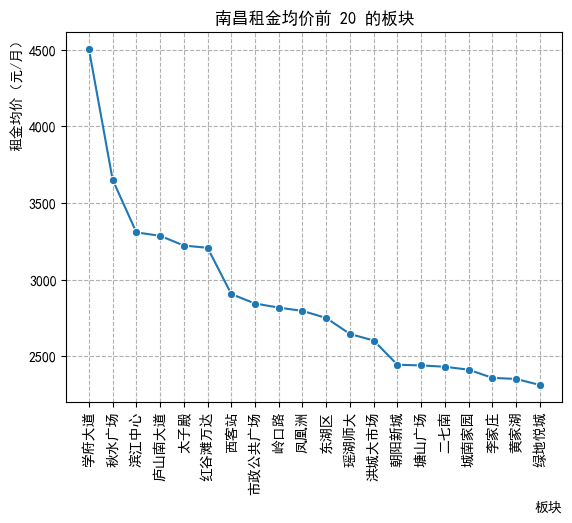

In [521]:
plot_block_price_avg(nc_block_price_avg, 'head', 20, '板块', '租金均价（元/月）', '南昌租金均价前 20 的板块')

南昌租金均价后 20 的板块：

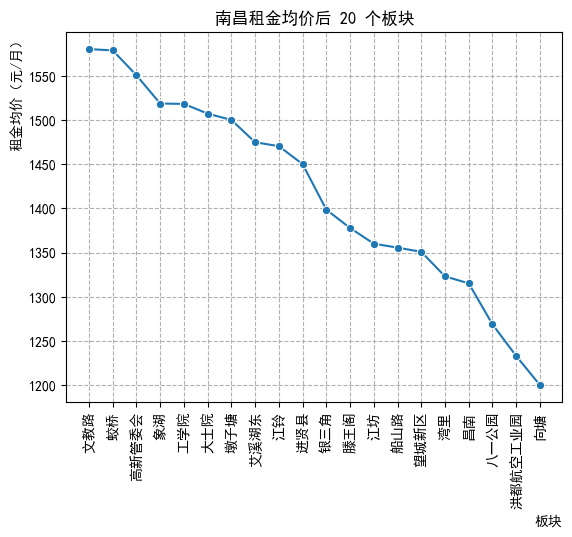

In [522]:
plot_block_price_avg(nc_block_price_avg, 'tail', 20, '板块', '租金均价（元/月）', '南昌租金均价后 20 个板块')

### 不同朝向对租金影响的分析

首先对每个城市的租房信息进行分析，计算出东南西北四个朝向各有哪些房子

然后对这四个方向的房子分别画出箱线图以比较不同朝向的单位面积租金分布情况

下面两个函数分别统计了各朝向的房子和绘制箱型图

In [523]:
# 计算城市东南西北四个朝向各有哪些房子，
def classify_by_direction(df: pd.DataFrame) -> pd.DataFrame:
    df['单位面积租金'] = df['租金'] / df['面积']
    return pd.DataFrame({
        '东': df[df['朝向'].str.contains('东')]['单位面积租金'].sort_values(ascending=False),
        '南': df[df['朝向'].str.contains('南')]['单位面积租金'].sort_values(ascending=False),
        '西': df[df['朝向'].str.contains('西')]['单位面积租金'].sort_values(ascending=False),
        '北': df[df['朝向'].str.contains('北')]['单位面积租金'].sort_values(ascending=False)
    })

In [524]:
# 根据按朝向分类的数据绘制箱型图
def plot_direction_price_boxplot(data: pd.DataFrame, xlabel: str, ylabel: str, title: str) -> None:
    # 创建画布
    plt.figure()

    # 绘制箱型图
    sns.boxplot(data=data)

    # 设置坐标轴标签
    plt.xlabel(xlabel, loc='right')
    plt.ylabel(ylabel, loc='top')

    # 设置标题
    plt.title(title)

    # 设置网格线
    plt.grid(linestyle='--')

    # 展示图形
    plt.show()

#### 北京不同朝向的单位面积租金分布情况

In [525]:
# 按朝向给房屋分类并保留单位面积租金
bj_direction_unit_price_df = classify_by_direction(bj_df)
bj_direction_unit_price_df.head()

,东,南,西,北
0,86.516854,NaN,NaN,86.516854
1,NaN,128.645554,NaN,NaN
2,NaN,98.285236,NaN,98.285236
3,NaN,63.636364,NaN,NaN
4,NaN,NaN,80.769231,NaN


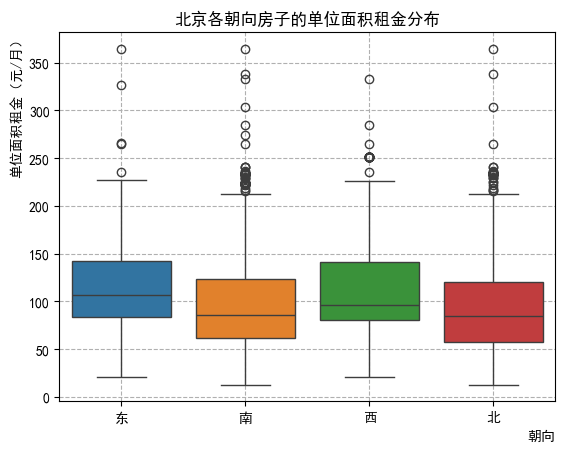

In [526]:
# 绘制箱型图，比较北京各朝向房子的单位面积租金分布
plot_direction_price_boxplot(bj_direction_unit_price_df, '朝向', '单位面积租金（元/月）', '北京各朝向房子的单位面积租金分布')

可以看到在北京朝东的房屋总体上来说单位面积租金更高，朝北的房子总体上单位面积租金最低

#### 上海不同朝向的单位面积租金分布情况

In [527]:
# 按朝向给房屋分类并保留单位面积租金
sh_direction_unit_price_df = classify_by_direction(sh_df)
sh_direction_unit_price_df.head()

,东,南,西,北
0,NaN,54.619079,NaN,54.619079
1,NaN,112.518519,NaN,NaN
2,NaN,164.896442,NaN,NaN
3,NaN,69.736842,NaN,NaN
4,56.818182,56.818182,NaN,NaN


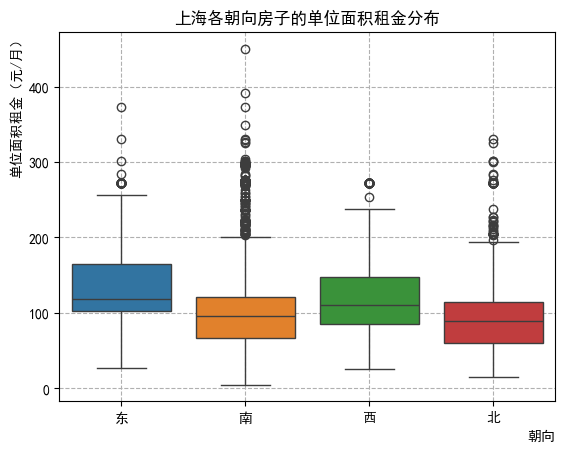

In [528]:
# 绘制箱型图，比较上海各朝向房子的单位面积租金分布
plot_direction_price_boxplot(sh_direction_unit_price_df, '朝向', '单位面积租金（元/月）', '上海各朝向房子的单位面积租金分布')

可以看到整体上海朝东的房子单位面积租金最高，朝北的房子单位面积租金最低

#### 广州不同朝向的单位面积租金分布情况

In [529]:
# 按朝向给房屋分类并保留单位面积租金
gz_direction_unit_price_df = classify_by_direction(gz_df)
gz_direction_unit_price_df.head()

,东,南,西,北
0,NaN,NaN,NaN,47.058824
1,NaN,NaN,NaN,158.970588
2,NaN,NaN,NaN,37.662338
3,NaN,47.435897,NaN,NaN
4,167.745098,NaN,NaN,NaN


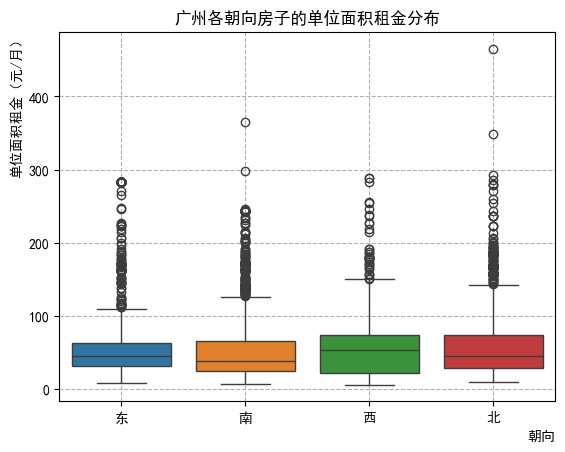

In [530]:
# 绘制箱型图，比较广州各朝向房子的单位面积租金分布
plot_direction_price_boxplot(gz_direction_unit_price_df, '朝向', '单位面积租金（元/月）', '广州各朝向房子的单位面积租金分布')

可以看到整体上朝西的房子单位面积租金最高，朝南的房子单位面积租金最低

#### 深圳不同朝向的单位面积租金分布情况

In [531]:
# 按朝向给房屋分类并保留单位面积租金
sz_direction_unit_price_df = classify_by_direction(sz_df)
sz_direction_unit_price_df.head()

,东,南,西,北
0,NaN,NaN,NaN,118.965517
1,NaN,88.888889,NaN,88.888889
2,NaN,NaN,88.135593,88.135593
3,NaN,NaN,254.878049,254.878049
4,NaN,61.538462,61.538462,NaN


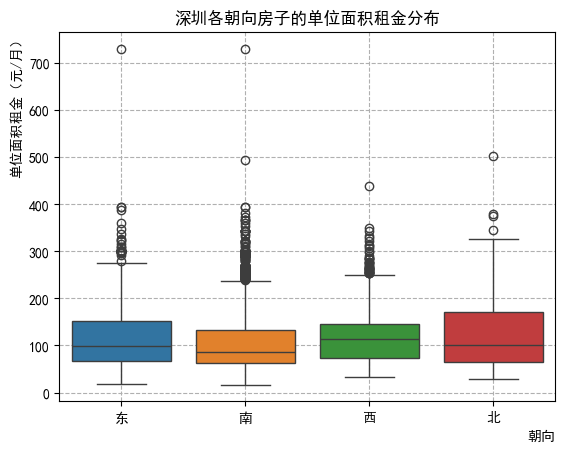

In [532]:
# 绘制箱型图，比较深圳各朝向房子的单位面积租金分布
plot_direction_price_boxplot(sz_direction_unit_price_df, '朝向', '单位面积租金（元/月）', '深圳各朝向房子的单位面积租金分布')

可以看到整体上深圳朝西的房子单位面积租金最高，朝南的房子单位面积租金最低

#### 南昌不同朝向的单位面积租金分布情况

In [533]:
# 按朝向给房屋分类并保留单位面积租金
nc_direction_unit_price_df = classify_by_direction(nc_df)
nc_direction_unit_price_df.head()

,东,南,西,北
0,41.666667,NaN,NaN,NaN
1,NaN,16.326531,NaN,NaN
2,NaN,54.666146,NaN,NaN
3,NaN,26.326874,NaN,26.326874
4,NaN,20.833333,NaN,20.833333


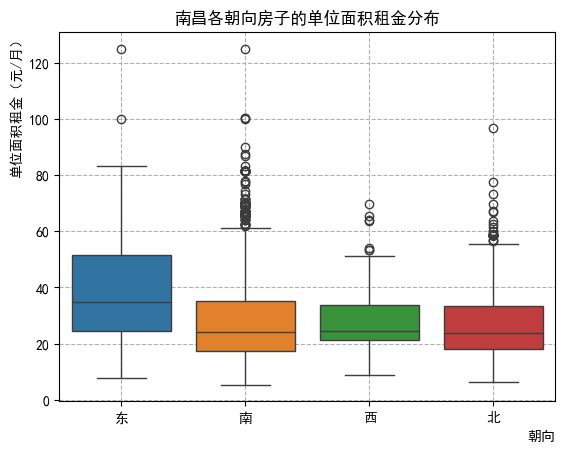

In [534]:
# 绘制箱型图，比较南昌各朝向房子的单位面积租金分布
plot_direction_price_boxplot(nc_direction_unit_price_df, '朝向', '单位面积租金（元/月）', '南昌各朝向房子的单位面积租金分布')

可以看到整体上南昌朝东的房子单位面积租金最高，朝北的房子单位面积售价最低

各个城市朝向与单位面积租金的关系总结如下：

- 北京：朝东最高，朝北最低
- 上海：朝东最高，朝北最低
- 广州：朝西最高，朝南最低
- 深圳：朝西最高，朝东最低
- 南昌：朝东最高，朝北最低

出现这种分布的原因可能与气候有关，相对北方的城市如北京、上海、南昌都是朝北的价格最低，因为北边冬季日照不如南边多；相对南方的城市如广州和深圳，由于温度较高，需要避开东南阳光照射较多的方向

### 各城市人均 GDP 与单位面积租金关系的分析与比较

根据上网获取的信息，总结出各城市人均 GDP 如下：

In [535]:
gdp = pd.Series({
    '北京': 164904,
    '上海': 155606,
    '广州': 133960,
    '深圳': 157575,
    '南昌': 91855
}, name='各城市人均 GDP（元）')
gdp

北京    164904
上海    155606
广州    133960
深圳    157575
南昌     91855
Name: 各城市人均 GDP（元）, dtype: int64

各个城市的单位面积租金关系如下：

In [536]:
unit_price_df = pd.DataFrame(
    {
        '北京': bj_df['租金'] / bj_df['面积'],
        '上海': sh_df['租金'] / sh_df['面积'],
        '广州': gz_df['租金'] / gz_df['面积'],
        '深圳': sz_df['租金'] / sz_df['面积'],
        '南昌': nc_df['租金'] / nc_df['面积']
    }
)
unit_price_df.head()

,北京,上海,广州,深圳,南昌
0,86.516854,54.619079,47.058824,118.965517,41.666667
1,128.645554,112.518519,158.970588,88.888889,16.326531
2,98.285236,164.896442,37.662338,88.135593,54.666146
3,63.636364,69.736842,47.435897,254.878049,26.326874
4,80.769231,56.818182,167.745098,61.538462,20.833333


为提高代码复用性，将绘制折线图和箱线图的过程封装为以下函数：

In [537]:
def plot_line_boxplot(linedata: pd.Series, boxdata: pd.DataFrame,
                      linelabel: str, boxlable: str, xlabel) -> None:
    # 设置画布大小
    fig = plt.figure()

    # 折线图
    lineax = fig.add_subplot(1, 1, 1)
    lineax.set_xlabel(xlabel, loc='right')
    lineax.set_ylabel(linelabel, loc='top')
    sns.lineplot(x=linedata.index, y=linedata.values,
                 marker='o', linestyle='--', label=linelabel, ax=lineax)
    # 添加标签
    for x, y in zip(linedata.index, linedata.values):
        lineax.text(x, y, y, ha='center', va='bottom', fontsize=12)

    # 单位面积租金箱线图
    boxplot = lineax.twinx()
    boxplot.set_ylabel(boxlable, loc='top')
    sns.boxplot(data=boxdata)

    # 添加网格
    lineax.grid(linestyle='--')

    # 展示图形
    plt.show()

在同一幅图中绘制人均 GDP 的折线图与各城市单位面积租金分布的箱线图：

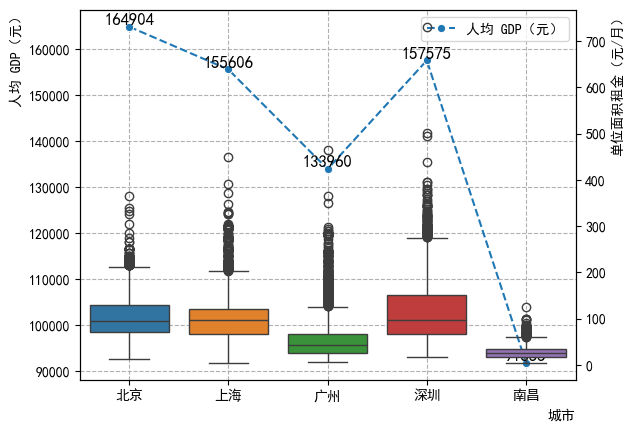

In [538]:
plot_line_boxplot(gdp, unit_price_df, '人均 GDP（元）', '单位面积租金（元/月）', '城市')

为了比较更清晰，我们再看一下单位面积租金的均值占各城市人均 GDP 的比例：

In [539]:
# 计算单位面积租金均值 / 人均 GDP
unit_price_gdp_rate = pd.Series({
    '北京': (bj_df['租金'] / bj_df['面积']).mean() / gdp['北京'],
    '上海': (sh_df['租金'] / sh_df['面积']).mean() / gdp['上海'],
    '广州': (gz_df['租金'] / gz_df['面积']).mean() / gdp['广州'],
    '深圳': (sz_df['租金'] / sz_df['面积']).mean() / gdp['深圳'],
    '南昌': (nc_df['租金'] / nc_df['面积']).mean() / gdp['南昌']
}, name='单位面积租金均值 / 人均 GDP')
unit_price_gdp_rate

北京    0.000619
上海    0.000640
广州    0.000431
深圳    0.000728
南昌    0.000308
Name: 单位面积租金均值 / 人均 GDP, dtype: float64

按照上述比例绘制折线图，同样封装成函数：

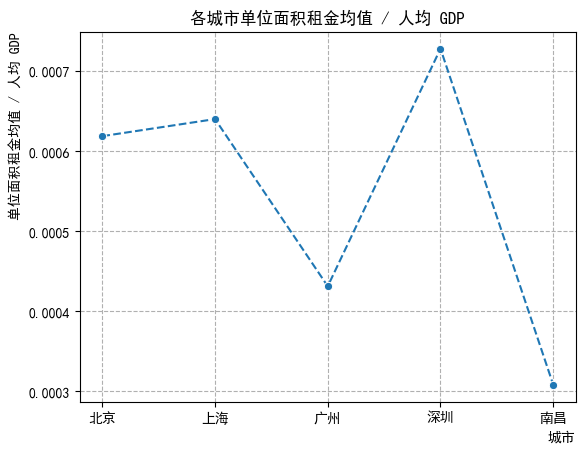

In [540]:
def plot_rate_line(data: pd.Series, xlabel: str, ylabel: str, title: str) -> None:
    # 创建画布
    plt.figure()

    # 绘制折线图
    sns.lineplot(x=data.index, y=data.values, marker='o', linestyle='--')

    # 设置坐标轴标签
    plt.xlabel(xlabel, loc='right')
    plt.ylabel(ylabel, loc='top')

    # 设置标题
    plt.title(title)

    # 设置网格线
    plt.grid(linestyle='--')

    # 展示图形
    plt.show()

# 绘制折线图，比较各城市的单位面积租金 / 人均 GDP
plot_rate_line(unit_price_gdp_rate, '城市', '单位面积租金均值 / 人均 GDP', '各城市单位面积租金均值 / 人均 GDP')

可以看到，按照各城市单位面积租金均值与人均 GDP 的比例来说，南昌的支出/收入最低，相对而言性价比最高

### 各城市平均工资与租金关系的分析与比较

根据网上获取的信息，总结出各城市平均工资（2022年四季度）如下：

In [541]:
salary = pd.Series({
    '北京': 13930, 
    '上海': 13832, 
    '广州': 11710, 
    '深圳': 13086, 
    '南昌': 9050
}, name='各城市月平均工资（元/月）')
salary

北京    13930
上海    13832
广州    11710
深圳    13086
南昌     9050
Name: 各城市月平均工资（元/月）, dtype: int64

在同一幅图中绘制人均 GDP 的折线图与各城市单位面积租金分布的箱线图：

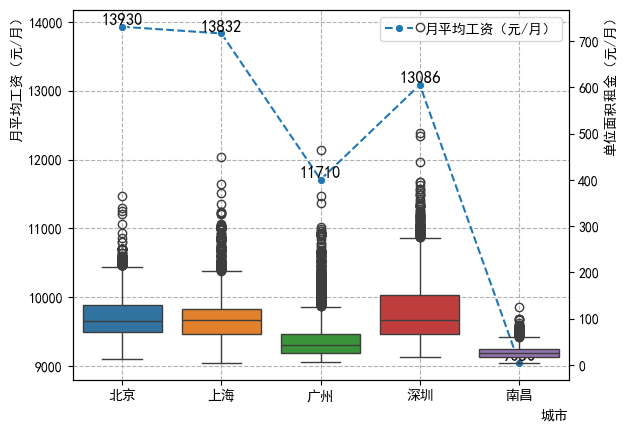

In [542]:
plot_line_boxplot(salary, unit_price_df, '月平均工资（元/月）', '单位面积租金（元/月）', '城市')

为了比较更清晰，再分析比较一下各城市单位面积租金均价与平均工资的比例：

In [543]:
# 计算单位面积租金均值 / 月平均工资
unit_price_salary_rate = pd.Series({
    '北京': (bj_df['租金'] / bj_df['面积']).mean() / salary['北京'],
    '上海': (sh_df['租金'] / sh_df['面积']).mean() / salary['上海'],
    '广州': (gz_df['租金'] / gz_df['面积']).mean() / salary['广州'],
    '深圳': (sz_df['租金'] / sz_df['面积']).mean() / salary['深圳'],
    '南昌': (nc_df['租金'] / nc_df['面积']).mean() / salary['南昌']
}, name='单位面积租金均值 / 月平均工资')
unit_price_salary_rate

北京    0.007328
上海    0.007203
广州    0.004936
深圳    0.008769
南昌    0.003131
Name: 单位面积租金均值 / 月平均工资, dtype: float64

按照上述比例绘制成折线图：

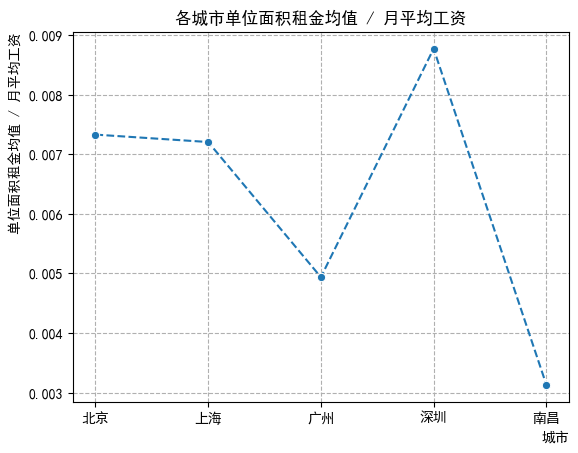

In [544]:
plot_rate_line(unit_price_salary_rate, '城市', '单位面积租金均值 / 月平均工资', '各城市单位面积租金均值 / 月平均工资')

总体来说，深圳的单位面积租金的均值与当地月平均工资的比例最高，说明在深圳相对而言租房的负担最重

### 自选题目：分析比较各城市租房面积与月租金的关系

首先分析一下各个城市租房面积的分布情况

将绘制一个城市租房面积的过程封装为以下函数：

In [545]:
def plot_area_dis(data: pd.DataFrame, xlabel: str, ylabel: str, title: str) -> None:  
    # 绘制租房面积的分布
    bins = range(0, 500, 50)
    sns.displot(data['面积'], bins=bins)

    # 设置坐标轴标签
    plt.xlabel(xlabel, loc='right')
    plt.ylabel(ylabel, loc='top')

    # 设置坐标轴刻度
    plt.xticks(bins)

    # 设置标题
    plt.title(title)

    plt.show()

下面绘制各个城市租房面积的分布情况：

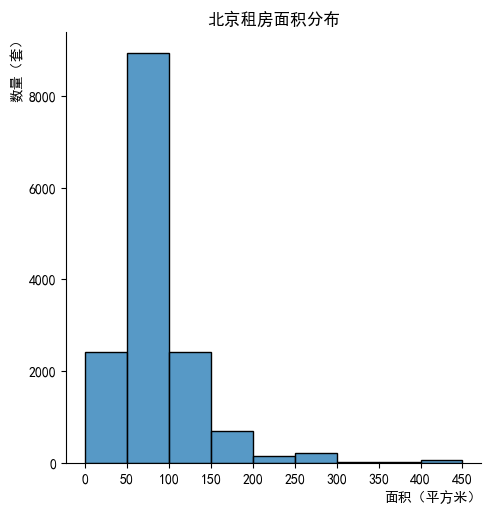

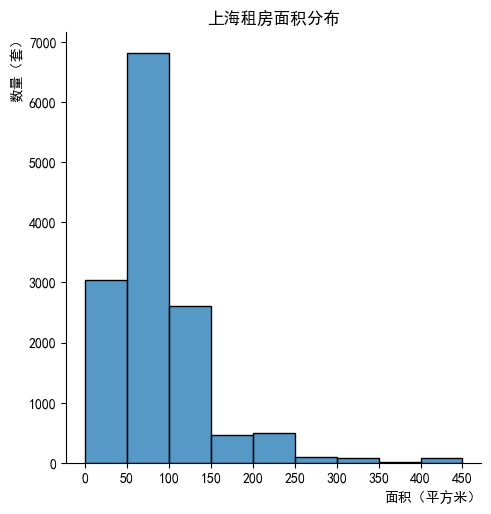

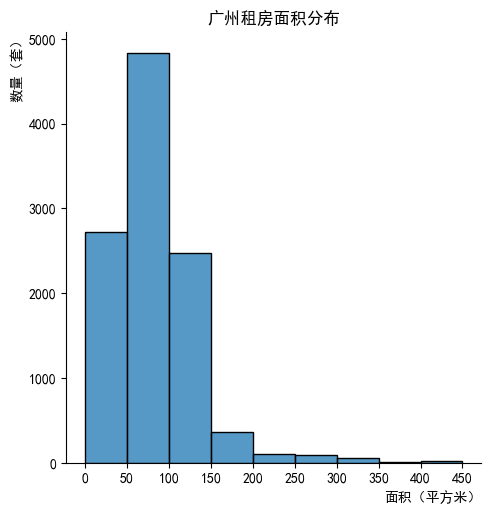

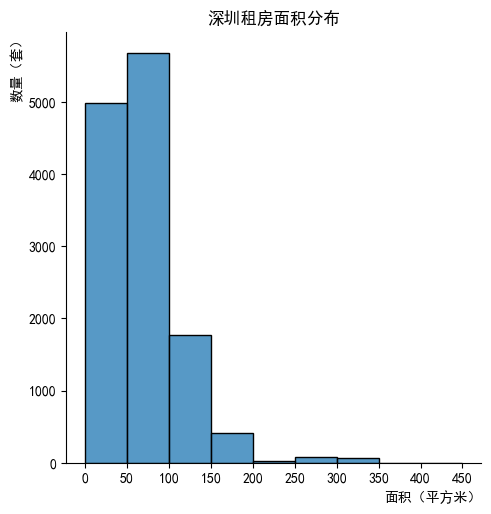

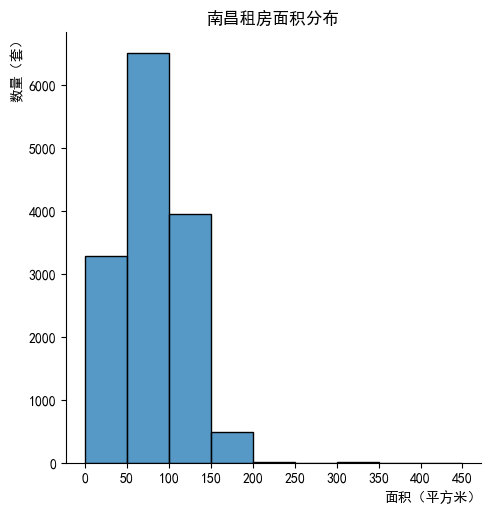

In [546]:
df_dict = {
    '北京': bj_df,
    '上海': sh_df,
    '广州': gz_df,
    '深圳': sz_df,
    '南昌': nc_df
}

for i, (city, df) in enumerate(df_dict.items()):
        plot_area_dis(df, '面积（平方米）', '数量（套）', f'{city}租房面积分布')

可以看出，绝大部分租房面积都在 200 平方米以内，各个城市不同面积区间的占比不同


下面绘制散点图观察各城市租房面积与月租金的关系：

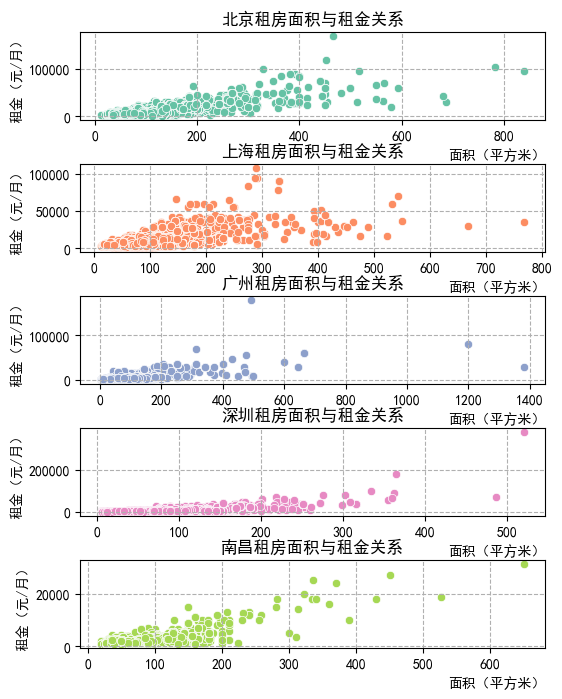

In [547]:
fig, ax = plt.subplots(5, 1, figsize=(6, 8))

# 调整子图之间的间距
plt.subplots_adjust(hspace=0.5)

# 设置调色板
palette = sns.color_palette('Set2', 5)

# 绘制租房面积与租金关系散点图
def plot_area_price_scatter(data: pd.DataFrame, ax: plt.Axes,
                            xlabel: str, ylabel: str, title: str, i: int) -> None:
    # 绘制散点图
    sns.scatterplot(data=data, x='面积', y='租金', ax=ax, color=palette[i])

    # 设置坐标轴标签
    ax.set_xlabel(xlabel, loc='right')
    ax.set_ylabel(ylabel, loc='top')

    # 设置标题
    ax.set_title(title)

    # 设置网格线
    ax.grid(linestyle='--')

# 绘制各城市的租房面积与租金关系散点图
for i, (city, df) in enumerate(df_dict.items()):
    plot_area_price_scatter(df, ax[i], '面积（平方米）', '租金（元/月）', f'{city}租房面积与租金关系', i)

由散点图可以看出，各城市都是 200 平方米内的房屋占大多数，售价也较为集中

200 平方米以后随着面积和租金的提高，房屋数量也越来越少

总体上租房面积与月租金有一定的线性关系，即租房面积越大租金越高

## 项目总结



此次住房数据分析项目完成了以下方面的数据分析与可视化：

- 北京、上海、广州、深圳、南昌五个城市
- 月租金的均价、最高价、最低价、中位数比较分析
- 单位面积租金的均线、最高价、最低价、中位数比较分析
- 一、二、三居室的月租金均价、最高价、最低价、中位数
- 月租金均价前 20 的板块、后 20 的板块
- 东、南、西、北四个朝向月租金的分布
- 人均 GDP 与单位面积租金的关系
- 平均工资与单位面积租金的关系
- 房屋面积与月租金的关系

完成此项目的过程中我有以下收获：

- 学会了使用 BeautifulSoup 进行静态网页数据的爬取
- 巩固了程序设计的优化方法，输出日志调试、封装与抽象提升代码复用性等
- 巩固了 pandas 进行数据预处理的常用方法
- 学会了使用 Seaborn 进行数据可视化
- 巩固了 Jupyter Notebook 在数据分析中的使用方法